<h1 align="center"> Health Exploration and Analytics </h1> 
<h2 align="center"> Data Analysis on Factors Contributing to Health & Longevity </h2> 
<h3 align="center"> Maria Nikolova, BSc. </h3> 
<h3 align="center"> Data Science, SoftUni | 11-Feb-2018 | v1.00 </h3> 

## Abstract

This paper drills into the impact of different factors on human longevity and health. The paper is broken into several chapters each focusing on a different set of input variables and their correlation to certain target measures tied to longevity. The author loads datasets from the fields of Economics, Environment, Food and Drinks and Human Behavior. Each of these datasets is loaded, cleansed, modelled and then visualized and analyzed properly before conclusions are drawn. Time and Geography dimensions are taken into account. The author identifies that most strongly correlated are the input variables related to GDP per Capita and Food Intake. 

## Lab Setup

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as tm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from mpl_toolkits.basemap import Basemap

In [3]:
def fn_log_time(s_process_name, s_process_point):
    print("..::",s_process_name,s_process_point,"on", tm.strftime("%d %b %Y %H:%M:%S"),"::..")

def fn_get_df_shape(df):
    """ Returns the number of observations and features from a particular source file """
    i_observations_num = df.shape[0]
    i_features_num = df.shape[1]
    s_feature_name = df.columns[0]
    return "{} observations loaded on {} features for metric '{}'".format(i_observations_num, i_features_num, s_feature_name)

def fn_get_df_info(df):
    """ Prints dataframe info"""
    df.info()

def fn_rename_and_set_index(df):
    """ Function that accepts a dataframe, renames the first column to Country """  
    df_wrk=df.copy()
    df_wrk=df_wrk.rename(columns={df_wrk.columns[0]:"country"})
    df_wrk=df_wrk.set_index("country")
    return df_wrk

def fn_remove_rows_with_nulls (df, threshold):
    """ Accept a dataframe and remove all rows whose features data nulls trespass a certain threshold """
    i_num_columns=df.shape[1]
    ss_countries_null_num=df.isnull().sum(axis=1)
    ss_countries_null_pct=ss_countries_null_num/i_num_columns
    ss_countries_to_del=ss_countries_null_pct[ss_countries_null_pct<threshold]
    df_wrk=df.drop(ss_countries_to_del.index, axis=0)
    return df_wrk

def fn_unpivot_years(df, s_measure_col_name):
    """ Function takes a dataframe and unpivots the years to rows, leaving the src file measure as a column """
    df_wrk=df.copy()
    df_wrk=df_wrk.reset_index(level=0)
    df_wrk=df_wrk.melt(id_vars="country", var_name="year", value_name=s_measure_col_name)
    return df_wrk

def fn_get_dataset_years_range(df, s_df_name):
    """ Function checks on the range of years data available in the source dataset"""
    print(s_df_name,":", df.columns[0],"-",df.columns[-1])
    
def fn_check_float_dtypes(df,s_df_name):
    """ Function checks for the dataframe column types equal to float"""
    for item in df.dtypes:
        if item != "float64":
            print(s_df_name,"dataset features non-[float64] format. STATUS: ERROR")
            break
    print(s_df_name,"dataset [float64] data format confirmed. STATUS: OK.") 
    
def fn_identify_countries_with_nulls (df):
    """ Funcion calculates the percentage of missing data points for each country in the dataset"""
    ss_countries_sorted=df.isnull().sum(axis=1).sort_values(ascending=False)
    ss_countries_with_nulls=ss_countries_sorted[ss_countries_sorted>0]
    ss_countries_with_nulls_pct=ss_countries_with_nulls/df.shape[1]
    if len(ss_countries_with_nulls_pct)==0:
        return 'No missing values for countries in this dataset.'
    else: 
        return ss_countries_with_nulls_pct    

def fn_identify_redundant_countries (df1, df2):
    """Function receives 2 dataframes and returns a tuple of arrays from countries that do not interect"""
    a_df1_country_list_full=df1.index.tolist()
    a_df2_country_list_full=df2.index.tolist()
    a_country_list_intersect=(set(a_df1_country_list_full) & set(a_df2_country_list_full))
    a_countries_to_delete_from_df1= [item for item in a_df1_country_list_full if item not in a_country_list_intersect]
    a_countries_to_delete_from_df2= [item for item in a_df2_country_list_full if item not in a_country_list_intersect]
    return (a_countries_to_delete_from_df1,a_countries_to_delete_from_df2)

def fn_check_equal_shape (df1, df2):
    """ Function checks two datafames for equality in the shapes """
    df1_shape=df1.shape
    df2_shape=df2.shape
    if df1_shape != df2_shape:
        raise ValueError('[User exception]: Dataframes shape is not equal. Please investigate.')
        
def fn_plot_countries_measure_per_year(df, a_countries, a_years, s_measure):
    """ Function plots a number of countries over a period of time for a particular measure """
    fig, ax = plt.subplots(figsize=(17, 7)) 
    for item in a_countries:
        country = df[(df['country'] == item) & (df['year'].isin(a_years))]
        country_by_measure = country.loc[:,s_measure].tolist()
        ax.plot(a_years, country_by_measure, label=country.country.unique()[0])
        legend = ax.legend(loc='upper center', shadow=True)
        plt.grid(True)
    plt.xlabel('Years')
    plt.ylabel('Measure')
    plt.title('Country Data Over Time')
    plt.xticks(a_years, rotation="vertical")
    plt.show()

def fn_plot_measures_by_country_per_years(df, s_country, a_years, a_measures):
    """ Function plots the development of measures over time for a particular country"""
    fig, ax = plt.subplots(figsize=(17, 7))
    df_country_data = df[(df['country'] == s_country) & (df['year'].isin(a_years))]
    df_measure_columns = df_country_data.loc[:,a_measures]
    for item in a_measures:
        ss_curr_measure = df_measure_columns.loc[:,item]
        ax.plot(a_years, ss_curr_measure, label=item)
        legend = ax.legend(loc='upper center', shadow=True)
        plt.grid(True)
    plt.xlabel('Years')
    plt.ylabel('Measure')
    plt.title(s_country + ": Measures over years")
    plt.xticks(a_years, rotation="vertical")
    plt.show() 
    
def fn_plot_measure_by_countries(df, s_measure, s_title):
    """ Function plots bars for top 25 and botton 25 countries based on a particular measure """
    ss_measure_mean_per_country=df.groupby("country")[s_measure].mean()
    ss_measure_mean_per_country_low=ss_measure_mean_per_country.sort_values().head(25)
    ss_measure_mean_per_country_high=ss_measure_mean_per_country.sort_values().tail(25)
    ss_measure_mean_per_country=ss_measure_mean_per_country_high.append(ss_measure_mean_per_country_low)
    ss_measure_mean_per_country=ss_measure_mean_per_country.sort_values()
    fig, ax = plt.subplots(figsize=(17, 7))
    plt.bar(range(len(ss_measure_mean_per_country)), ss_measure_mean_per_country)
    plt.xticks(range(len(ss_measure_mean_per_country)), ss_measure_mean_per_country.index, rotation = "vertical")
    plt.title(s_title)
    plt.show()
    
def fn_calculate_correlation_between_two_features(df,s_measure1, s_measure2):
    """ Function calculates and categorizes the correlation coefficient between two input measures per dataframe """
    num_corr=df[s_measure1].corr(df[s_measure2])
    if (num_corr > 0) & (num_corr < 0.3):
        print('Low Positive Correlation:', "%.3f" % num_corr)
    elif (num_corr > 0.3) & (num_corr < 0.5):
        print('Moderate Positive Correlation:', "%.3f" % num_corr)
    elif (num_corr > 0.5) & (num_corr < 0.7):
        print('Significant Positive Correlation:', "%.3f" % num_corr)
    elif (num_corr > 0.7) & (num_corr < 0.9):
        print('High Positive Correlation:', "%.3f" % num_corr)
    elif num_corr > 0.9:
         print('Extra High Positive Correlation:', "%.3f" % num_corr)
    elif (num_corr < 0) & (num_corr > -0.3):
        print('Low Negative Correlation:', "%.3f" % num_corr)
    elif (num_corr < -0.3) & (num_corr > -0.5):
        print('Moderate Negative Correlation:', "%.3f" % num_corr)
    elif (num_corr < -0.5) & (num_corr > -0.7):
        print('Significant Negative Correlation:', "%.3f" % num_corr)
    elif (num_corr < -0.7) & (num_corr > -0.9):
        print('High Negative Correlation:', "%.3f" % num_corr)
    elif num_corr < -0.9:
         print('Extra High Negative Correlation:', "%.3f" % num_corr)
            
def fn_plot_linear_regression(df, s_variable_measure,s_target_measure):
    """ Function plots the linear regression between two input measures in a dataframe """
    x=df[s_variable_measure]
    y=df[s_target_measure]
    
    # Reshaping the values
    x, y = x.values.reshape(-1,1), y.values.reshape(-1, 1)
    # Create and setup the linear regression object
    obj_lin_regression = LinearRegression()
    obj_lin_regression.fit(x,y)
    # Get slope and intercept of fitted line
    a = obj_lin_regression.coef_
    b = obj_lin_regression.intercept_
    predictions = obj_lin_regression.predict(x)
    print ("Derived Target Formula: y = {0} * x + {1}".format("%.8f" % a[0][0], "%.8f" % b[0])) 

    # Plot the Original Model (Orange) and Predictions (Blue)
    plt.scatter(x, y,  color='orange')
    plt.plot(x, predictions, color='blue',linewidth=3)
    plt.show()

def fn_remove_years_data (df, n_thres, s_sign):
    """ Function removes years of data below or above a certain threshold """
    df_wrk=df.copy()
    a_all_years=df.columns.tolist()
    if s_sign=="<":
        a_columns_to_del=list(filter(lambda x: int(x)<n_thres, a_all_years))
    elif s_sign==">":
        a_columns_to_del=list(filter(lambda x: int(x)>n_thres, a_all_years))
    else:
        raise ValueError("Unproper use of function. Please use < or > as last parametr")
    df_wrk=df_wrk.drop(a_columns_to_del, axis=1)
    return df_wrk 

def fn_convert_column_types_to_int (df):
    """ Function converts column names to integer """
    a_columns_init=df.columns.tolist()
    a_columns_new=list(map(int, a_columns_init))
    df.columns=a_columns_new
    return df

def fn_draw_world_by_measure(df, num_year, s_measure):
    """ Function draws a map of the world and categorizes pins by a measure """
    df_countries_sorted = df[(df['year'] == num_year)][['country',s_measure,'longitude','latitude']].sort_values(by=[s_measure]).reset_index()
    a_longitude =  df_countries_sorted['longitude'].tolist()
    a_latitude = df_countries_sorted['latitude'].tolist()
    areas = []
    colors = []
    fig, ax = plt.subplots(figsize = (15, 10))
    m = Basemap(projection = "cyl")
    num_min_life_exp = df_countries_sorted[s_measure].head(1).iloc[0]
    num_max_life_exp = df_countries_sorted[s_measure].tail(1).iloc[0]
    for index,row in df_countries_sorted.iterrows():
        if row[s_measure] >= num_max_life_exp-7:
            colors.append('green')
            areas.append(30)
        elif row[s_measure] <= num_min_life_exp+15:
            colors.append('red')
            areas.append(30)
        else:
            colors.append('blue')
            areas.append(20)
    m.drawcoastlines()
    m.drawcountries()
    plt.scatter(a_longitude, a_latitude,s=areas, c=colors)
    plt.show()
    
def fn_check_years_with_minimum_data_gaps(df,n_thres):
    """ Functiom checks for countries with missing data points below a certain threshold """
    ss_num_of_gaps=df.isnull().sum(axis=0)
    ss_list_of_cols=ss_num_of_gaps[ss_num_of_gaps<=n_thres]
    return ss_list_of_cols

def fn_plot_correlation_large_matrix (df):
    """ Function plots a large size correlation matrix """
    fig = plt.figure(figsize=(20, 13))
    plt.matshow(df.corr(), fignum=1)
    plt.xticks(range(len(df.columns)), df.columns, rotation = 'vertical')
    plt.yticks(range(len(df.columns)), df.columns)
    plt.grid(True)
    plt.colorbar()
    plt.show()
    
def fn_plot_correlation_matrix (df):
    """ Function plots a standard size correlation matrix """
    fig, ax = plt.subplots(figsize=(10,7))
    df_corr = df.corr()
    sns.set_style("whitegrid", {'grid.linestyle': '--'})
    sns.heatmap(df_corr, xticklabels=df_corr.columns, yticklabels=df_corr.columns)
    
def fn_normalize_datasets_for_ten_years_reporting (df,n_min_year,n_max_year):
    """ Function normalizes a dataframe for modelling using input time range """
    df_wrk=df.copy()
    df_wrk=fn_remove_years_data(df_wrk,n_min_year,"<")
    df_wrk=fn_remove_years_data(df_wrk,n_max_year,">")
    df_wrk=df_wrk.T.fillna(df_wrk.mean(axis=1)).T
    return df_wrk

def fn_plot_pie(a_labels, a_sizes, a_explode):
    """ Function plot a piechart of data for each input category """
    fig1, ax1 = plt.subplots(figsize=(17, 7))
    ax1.pie(a_sizes,explode=a_explode, labels=a_labels,autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')
    plt.show()

## 1. Paper Introduction

This paper aims to identify correlation between different economic and habitual factors from one side and overall health state and longevity on the other. The focus of the problem is to see "the big picture" -- how health differs among countries and what possible factors can contribute to this. 

This research is carried out based on Gapminder and ATUS source datasets available publicly and covering a wide range of historical input. The problem is divided into 3 main chapters:
* Chapter 1 – Analysis on Economical factors such as (#1001) GDP per Capita, (#1002) Agricultural Development, (#1003) CO2 Emissions, (#1004) Coal Consumption, (#1005) Electricity Consumption, (#1006) Industrial Development, (#1007) Services Sector Development, (#1008) Suicide Rate, (#1009) Healthcare Expenditure, (#1010) Urbanization and (#1011) Water Withdrawal Levels. KPIs are measured worldwide and broken into annual statistical data. 
* Chapter 2 – Analysis on (#2001) Alcohol Consumption, (#2002) Blood Pressure, (#2003) Body Mass Index, (#2004) Cholesterol, (#2005) Calorie Intake and (#2006) Sugar Intake. KPIs are measured worldwide and broken into annual statistical data. 
* Chapter 3 – Analysis on (#3001) Monthly Household Income, (#3002) Income vs Poverty, (#3003) Soft Drinks Consumption, (#3004) Physical Activities, (#3005) Fast Food Consumption, (#3006) Height/Weight, (#3007) Meat Consumption, (#3008) Milk Consumption, (#3009) Shopping Location of Choice, (#3010) BMI. KPIs come from an US survey for a single year. 


Each of these KPIs will be correlated to the following target measures – (#0001) Life Expectancy at Birth, (#0002) Child Mortality Rate or (#0003) Health Status. Correlation will be broken into categories in the scale low-high.

Each chapter will undergo the following analysis path:
* Introduction & Hypothesis Opening
* Data Acquisition
* Data Cleansing
* Data Modelling
* Data Visualizations & Hypothesis Closing

## 2. Economics & Demographics

### 2.1. Economics & Demographics - Chapter Introduction

The mission of Gapminder Foundation is to fight devastating ignorance with a fact-based worldview that everyone can understand. A number of datasets have been identified to properly the address critical KPIs over a period of time worldwide. Inside the data bank one can identify the following target measures against human health and longevity: (#0001) Life Expectancy at Birth, (#0002) Child Mortality Rate. The following variables are being examines for correlation:
* (#1001) GDP per Capita, 
* (#1002) Agricultural Development, 
* (#1003) CO2 Emissions, 
* (#1004) Coal Consumption, 
* (#1005) Electricity Consumption, 
* (#1006) Industrial Development, 
* (#1007) Services Sector Development, 
* (#1008) Suicide Rate, 
* (#1009) Healthcare Expenditure, 
* (#1010) Urbanization and 
* (#1011) Water Withdrawal Levels. 

## 2.2 Economics & Demographics - Data Acquisition

Data from the website is downloaded and saved in a subdirectory in the project folder. Each file is loaded as is without manual intervention to the source file.

In [4]:
#Loading the orignal datasets

fn_log_time("Datasets Loading", "started")

df_life_expectancy_at_birth_src=pd.read_excel("1. EconomicsAndDemographics/life_expectancy_at_birth.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_life_expectancy_at_birth_src))

df_under_five_mortality_rate_src=pd.read_excel("1. EconomicsAndDemographics/under_five_mortality_rate.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_under_five_mortality_rate_src))

df_urban_population_pct_src=pd.read_excel("1. EconomicsAndDemographics/urban_population_pct.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_urban_population_pct_src))

df_gdp_per_capita_src=pd.read_excel("1. EconomicsAndDemographics/gdp_per_capita.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_gdp_per_capita_src))

df_agriculture_gdp_pct_src=pd.read_excel("1. EconomicsAndDemographics/agriculture_gdp_pct.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_agriculture_gdp_pct_src))

df_industry_gdp_pct_src=pd.read_excel("1. EconomicsAndDemographics/industry_gdp_pct.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_industry_gdp_pct_src))

df_services_gdp_pct_src=pd.read_excel("1. EconomicsAndDemographics/services_gdp_pct.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_services_gdp_pct_src))

df_total_health_expenditure_gdp_pct_src=pd.read_excel("1. EconomicsAndDemographics/total_health_expenditure_gdp_pct.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_total_health_expenditure_gdp_pct_src))

df_water_withdrawal_per_capita_src=pd.read_excel("1. EconomicsAndDemographics/water_withdrawal_per_capita.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_water_withdrawal_per_capita_src))

df_coal_consumption_per_capita_src=pd.read_excel("1. EconomicsAndDemographics/coal_consumption_per_capita.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_coal_consumption_per_capita_src))

df_carbon_dioxide_emissions_per_capita_src=pd.read_excel("1. EconomicsAndDemographics/carbon_dioxide_emissions_per_capita.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_carbon_dioxide_emissions_per_capita_src))

df_electricity_consumption_per_capita_src=pd.read_excel("1. EconomicsAndDemographics/electricity_consumption_per_capita.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_electricity_consumption_per_capita_src))

df_suicide_per_10k_src=pd.read_excel("1. EconomicsAndDemographics/suicide_per_10k.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_suicide_per_10k_src))

fn_log_time("Datasets Loading", "ended successfully")

..:: Datasets Loading started on 11 Feb 2018 16:29:24 ::..
260 observations loaded on 218 features for metric 'Life expectancy'
260 observations loaded on 82 features for metric 'CME under 5 mortality'
273 observations loaded on 53 features for metric 'Urban population (% of total)'
262 observations loaded on 217 features for metric 'GDP per capita'
270 observations loaded on 52 features for metric 'Agriculture, value added (% of GDP)'
213 observations loaded on 53 features for metric 'Industry, value added (% of GDP)'
213 observations loaded on 53 features for metric 'Services, etc., value added (% of GDP)'
262 observations loaded on 17 features for metric 'Total expenditure on health as percentage of GDP (gross domestic product)'
228 observations loaded on 11 features for metric 'Total water withdrawal per capita (m3/inhab/yr)'
272 observations loaded on 48 features for metric 'Coal Consumption per person (tonnes oil equivalent)'
235 observations loaded on 254 features for metric 'CO

A simple profiling on each of the loaded datasets to do sanity check before further processing.

In [5]:
# Profiling
fn_get_df_info(df_life_expectancy_at_birth_src)
#df_life_expectancy_at_birth_src.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Columns: 218 entries, Life expectancy to 2016
dtypes: float64(217), object(1)
memory usage: 442.9+ KB


## 2.3. Economics & Demographics - Data Cleansing

First operation is to normalize the columns by renaming the opening (measure name) column to `country` and setting it as an identifying index.

In [6]:
fn_log_time("Datasets Indexing", "started")
df_life_wrk=fn_rename_and_set_index(df_life_expectancy_at_birth_src)
df_under_five_wrk=fn_rename_and_set_index(df_under_five_mortality_rate_src)
df_urban_wrk=fn_rename_and_set_index(df_urban_population_pct_src)
df_gdp_wrk=fn_rename_and_set_index(df_gdp_per_capita_src)
df_agro_wrk=fn_rename_and_set_index(df_agriculture_gdp_pct_src)
df_industry_wrk=fn_rename_and_set_index(df_industry_gdp_pct_src)
df_services_wrk=fn_rename_and_set_index(df_services_gdp_pct_src)
df_health_wrk=fn_rename_and_set_index(df_total_health_expenditure_gdp_pct_src)
df_water_wrk=fn_rename_and_set_index(df_water_withdrawal_per_capita_src)
df_coal_wrk=fn_rename_and_set_index(df_coal_consumption_per_capita_src)
df_emissions_wrk=fn_rename_and_set_index(df_carbon_dioxide_emissions_per_capita_src)
df_electricity_wrk=fn_rename_and_set_index(df_electricity_consumption_per_capita_src)
df_suicide_wrk=fn_rename_and_set_index(df_suicide_per_10k_src)
fn_log_time("Datasets Indexing", "ended")

..:: Datasets Indexing started on 11 Feb 2018 16:29:28 ::..
..:: Datasets Indexing ended on 11 Feb 2018 16:29:28 ::..


As it turns out some of the columns names (representing `year`) are Integer and some are Strings. Let's convert all to Integer for consistency and easier handling down the road. Meanwhile verify that all data points are numerics (float64). 

In [7]:
fn_check_float_dtypes(df_life_wrk,'Life Expectancy at Birth')
fn_check_float_dtypes(df_under_five_wrk,'Under Five Mortality')
fn_check_float_dtypes(df_urban_wrk,'Urban Population')
fn_check_float_dtypes(df_gdp_wrk,'GDP Per Capita')
fn_check_float_dtypes(df_agro_wrk,'Agriculture GDP')
fn_check_float_dtypes(df_industry_wrk,'Industry GDP')
fn_check_float_dtypes(df_services_wrk,'Services GDP')
fn_check_float_dtypes(df_health_wrk,'Health Expenditure GDP')
fn_check_float_dtypes(df_water_wrk,'Water Withdrawal')
fn_check_float_dtypes(df_coal_wrk,'Coal Consumption')
fn_check_float_dtypes(df_emissions_wrk,'CO2 Emissions')
fn_check_float_dtypes(df_electricity_wrk,'Electricity Consumption')
fn_check_float_dtypes(df_suicide_wrk,'Suicide Rate')

Life Expectancy at Birth dataset [float64] data format confirmed. STATUS: OK.
Under Five Mortality dataset [float64] data format confirmed. STATUS: OK.
Urban Population dataset [float64] data format confirmed. STATUS: OK.
GDP Per Capita dataset [float64] data format confirmed. STATUS: OK.
Agriculture GDP dataset [float64] data format confirmed. STATUS: OK.
Industry GDP dataset [float64] data format confirmed. STATUS: OK.
Services GDP dataset [float64] data format confirmed. STATUS: OK.
Health Expenditure GDP dataset [float64] data format confirmed. STATUS: OK.
Water Withdrawal dataset [float64] data format confirmed. STATUS: OK.
Coal Consumption dataset [float64] data format confirmed. STATUS: OK.
CO2 Emissions dataset [float64] data format confirmed. STATUS: OK.
Electricity Consumption dataset [float64] data format confirmed. STATUS: OK.
Suicide Rate dataset [float64] data format confirmed. STATUS: OK.


In [8]:
df_life_wrk=fn_convert_column_types_to_int(df_life_wrk)
df_under_five_wrk=fn_convert_column_types_to_int(df_under_five_wrk)
df_urban_wrk=fn_convert_column_types_to_int(df_urban_wrk)
df_gdp_wrk=fn_convert_column_types_to_int(df_gdp_wrk)
df_agro_wrk=fn_convert_column_types_to_int(df_agro_wrk)
df_industry_wrk=fn_convert_column_types_to_int(df_industry_wrk)
df_services_wrk=fn_convert_column_types_to_int(df_services_wrk)
df_health_wrk=fn_convert_column_types_to_int(df_health_wrk)
df_water_wrk=fn_convert_column_types_to_int(df_water_wrk)
df_coal_wrk=fn_convert_column_types_to_int(df_coal_wrk)
df_emissions_wrk=fn_convert_column_types_to_int(df_emissions_wrk)
df_electricity_wrk=fn_convert_column_types_to_int(df_electricity_wrk)
df_suicide_wrk=fn_convert_column_types_to_int(df_suicide_wrk)

The nature of the problem is to draw conclusions on a worldwide (humanity) scale. The geographical reach helps us identify patterns and mitigate the impact of cultural, environment and habitual factors. Nevertheless bad data can do more harm to the quantification of our analysis than the harm of ignoring (removing) certain countries or years with insufficient data points. Let us remove countries (rows) or years (columns) without any data per dataset. 

In [9]:
fn_log_time("Initial Null Data Cleansing", "started")

df_life_wrk=df_life_wrk.dropna(axis=0, how='all')
df_life_wrk=df_life_wrk.dropna(axis=1, how='all')

df_under_five_wrk=df_under_five_wrk.dropna(axis=0, how='all')
df_under_five_wrk=df_under_five_wrk.dropna(axis=1, how='all')

df_urban_wrk=df_urban_wrk.dropna(axis=0, how='all')
df_urban_wrk=df_urban_wrk.dropna(axis=1, how='all')

df_gdp_wrk=df_gdp_wrk.dropna(axis=0, how='all')
df_gdp_wrk=df_gdp_wrk.dropna(axis=1, how='all')

df_agro_wrk=df_agro_wrk.dropna(axis=0, how='all')
df_agro_wrk=df_agro_wrk.dropna(axis=1, how='all')

df_industry_wrk=df_industry_wrk.dropna(axis=0, how='all')
df_industry_wrk=df_industry_wrk.dropna(axis=1, how='all')

df_services_wrk=df_services_wrk.dropna(axis=0, how='all')
df_services_wrk=df_services_wrk.dropna(axis=1, how='all')

df_health_wrk=df_health_wrk.dropna(axis=0, how='all')
df_health_wrk=df_health_wrk.dropna(axis=1, how='all')

df_water_wrk=df_water_wrk.dropna(axis=0, how='all')
df_water_wrk=df_water_wrk.dropna(axis=1, how='all')

df_coal_wrk=df_coal_wrk.dropna(axis=0, how='all')
df_coal_wrk=df_coal_wrk.dropna(axis=1, how='all')

df_emissions_wrk=df_emissions_wrk.dropna(axis=0, how='all')
df_emissions_wrk=df_emissions_wrk.dropna(axis=1, how='all')

df_electricity_wrk=df_electricity_wrk.dropna(axis=0, how='all')
df_electricity_wrk=df_electricity_wrk.dropna(axis=1, how='all')

df_suicide_wrk=df_suicide_wrk.dropna(axis=0, how='all')
df_suicide_wrk=df_suicide_wrk.dropna(axis=1, how='all')

fn_log_time("Initial Null Data Cleansing", "ended successfully")

..:: Initial Null Data Cleansing started on 11 Feb 2018 16:29:28 ::..
..:: Initial Null Data Cleansing ended successfully on 11 Feb 2018 16:29:28 ::..


Now that we have removed the years without any data, let's see what we have left. This is required so we can merge and correlate the datasets down the road.

In [10]:
fn_get_dataset_years_range(df_life_wrk,'Life Expectancy at Birth')
fn_get_dataset_years_range(df_under_five_wrk,'Under Five Mortality')
fn_get_dataset_years_range(df_urban_wrk,'Urban Population')
fn_get_dataset_years_range(df_gdp_wrk,'GDP Per Capita')
fn_get_dataset_years_range(df_agro_wrk,'Agriculture GDP')
fn_get_dataset_years_range(df_industry_wrk,'Industry GDP')
fn_get_dataset_years_range(df_services_wrk,'Services GDP')
fn_get_dataset_years_range(df_health_wrk,'Health Expenditure GDP')
fn_get_dataset_years_range(df_water_wrk,'Water Withdrawal')
fn_get_dataset_years_range(df_coal_wrk,'Coal Consumption')
fn_get_dataset_years_range(df_emissions_wrk,'CO2 Emissions')
fn_get_dataset_years_range(df_electricity_wrk,'Electricity Consumption')
fn_get_dataset_years_range(df_suicide_wrk,'Suicide Rate')

Life Expectancy at Birth : 1800 - 2016
Under Five Mortality : 1931 - 2011
Urban Population : 1960 - 2011
GDP Per Capita : 1800 - 2015
Agriculture GDP : 1961 - 2011
Industry GDP : 1960 - 2010
Services GDP : 1960 - 2010
Health Expenditure GDP : 1995 - 2010
Water Withdrawal : 1962 - 2007
Coal Consumption : 1965 - 2011
CO2 Emissions : 1751 - 2012
Electricity Consumption : 1960 - 2011
Suicide Rate : 1950 - 2005


## 2.4. Ecomomics & Demographics - Data Modelling

Based on the year ranges published earlier we can identify the following batches that can be observed together so one relates KPIs appropriately scrapping too many valid points on the way. The data modelling exercise will be different for the different batches and covers the following methods:
* Normalization of Countries and Years until a data shape is equal. Datasets are then concatenated (appended) to each other
* Datasets are inner joined on a composite primary key (Country, Year). Non-intersected rows are discarded. 

There are pros and cons to each method but in any case the decision would be based on a case-per-case basis.

### 2.4.1. Economics & Demographics - Data Modelling - Dataset Batch 1

The first batch of data aims to cover the longest period of time possible. Based on the data availability explored in previous step the datasets with largest time range (1800-2015) are the following:
* (#1001) GDP per Capita,
* (#1003) CO2 Emissions

Considering the big overlap in years it will be useful to take the path towards normalizing the datasets and then appending them.

First step is to normalize the number of columns, where:
* (#0001) Life Expectancy at Birth - no change required.
* (#1001) GDP per Capita - missing data for 2016. Due to nature of the column we assume that GDP will not significantly change in one year, hence we can assume approximation for equality with last year (2015)
* (#1003) CO2 Emissions - annual data before 1800 should be discarded as redundant. Data for 2013-2016 is approximated to 2010.

In [11]:
# Normalizing Life Expectancy at Birth as a model dataset
df_life_corr_wrk=df_life_wrk.copy()
fn_get_dataset_years_range(df_life_corr_wrk,'Life Expectancy at Birth')

# Normalizing GDP dataset into [1800-2016] timeframe
df_gdp_corr_wrk=df_gdp_wrk.copy()
df_gdp_corr_wrk[2016]=df_gdp_corr_wrk[2015]
fn_get_dataset_years_range(df_gdp_corr_wrk,'GDP Per Capita')

# Normalizing Emissions dataset into [1800-2016] timeframe
df_emissions_corr_wrk=fn_remove_years_data(df_emissions_wrk,1800,"<")
### NOTES: USE A REGRESSION HERE, NOT TO HARD CODE THE LATEST WITH GOOD DATA (2010)
df_emissions_corr_wrk[2013]=df_emissions_corr_wrk[2010]
df_emissions_corr_wrk[2014]=df_emissions_corr_wrk[2010]
df_emissions_corr_wrk[2015]=df_emissions_corr_wrk[2010]
df_emissions_corr_wrk[2016]=df_emissions_corr_wrk[2010]
# df_emissions_corr_wrk.shape[1]
fn_get_dataset_years_range(df_emissions_corr_wrk,'CO2 Emissions')

Life Expectancy at Birth : 1800 - 2016
GDP Per Capita : 1800 - 2016
CO2 Emissions : 1800 - 2016


Now that columns look good, let us explore the missing points on row level (country). The purpose is to eliminate countries with highly scarce data (above certain per cent of the total columns count). For one country with small gap we can approximate based on closest known value. Non-intersecting countries are discarded. 

In [12]:
print("1. Cleansing Life Expectancy at Birth dataset in terms of missing Country data points...")
ss_countries_with_nulls=fn_identify_countries_with_nulls(df_life_corr_wrk)
print(ss_countries_with_nulls)
# Small countries with a lot of missing values - let's delete
df_life_corr_wrk=df_life_corr_wrk.drop(ss_countries_with_nulls.index.tolist(),axis=0)
print("*** The following countries have been deleted from the dataset:", ss_countries_with_nulls.index.tolist())
print("---------------------")

print("2. Cleansing Life GDP Per Capita dataset in terms of missing Country data points...")
ss_countries_with_nulls=fn_identify_countries_with_nulls(df_gdp_corr_wrk)
print(ss_countries_with_nulls)
ss_countries_with_nulls=ss_countries_with_nulls[ss_countries_with_nulls>0.10]
df_gdp_corr_wrk=df_gdp_corr_wrk.drop(ss_countries_with_nulls.index.tolist(),axis=0)
print("*** The following countries have been deleted from the dataset:", ss_countries_with_nulls.index.tolist())
num_country_ref_amt=df_gdp_corr_wrk.loc["Croatia",1820]
df_gdp_corr_wrk=df_gdp_corr_wrk.fillna(num_country_ref_amt)
print("*** Croatia data has been backfilled based on first known entry:", num_country_ref_amt)
print("---------------------")

print("3. Cleansing CO2 Emissions dataset in terms of missing Country data points...")
ss_countries_with_nulls=fn_identify_countries_with_nulls(df_emissions_corr_wrk)
print("Number of countries with missing data:", len(ss_countries_with_nulls))
print("*** Too many missing data points. CO2 Emissions dataset to be discarded from this correlation.")

1. Cleansing Life Expectancy at Birth dataset in terms of missing Country data points...
country
Tokelau                     0.995392
Åland                       0.953917
Dominica                    0.875576
American Samoa              0.875576
Andorra                     0.875576
Northern Mariana Islands    0.875576
Marshall Islands            0.875576
Bermuda                     0.875576
Channel Islands             0.691244
dtype: float64
*** The following countries have been deleted from the dataset: ['Tokelau', 'Åland', 'Dominica', 'American Samoa', 'Andorra', 'Northern Mariana Islands', 'Marshall Islands', 'Bermuda', 'Channel Islands']
---------------------
2. Cleansing Life GDP Per Capita dataset in terms of missing Country data points...
country
NaN        0.995392
Kosovo     0.875576
Croatia    0.092166
dtype: float64
*** The following countries have been deleted from the dataset: [nan, 'Kosovo']
*** Croatia data has been backfilled based on first known entry: 1350.0
----------

In [13]:
print ("Normalizing Life [Expectancy at Birth] and [GDP Per Capita] datasets in terms of common Country data:")
print("---------------------")
a_df1_redundant_countries, a_df2_redundant_countries = fn_identify_redundant_countries (df_life_corr_wrk, df_gdp_corr_wrk)
df_life_corr_wrk=df_life_corr_wrk.drop(a_df1_redundant_countries,axis=0)
print("The following countries have been deleted from the [Expectancy at Birth] dataset",a_df1_redundant_countries)
print("---------------------")
df_gdp_corr_wrk=df_gdp_corr_wrk.drop(a_df2_redundant_countries,axis=0)
print("The following countries have been deleted from the [GDP Per Capita] dataset",a_df2_redundant_countries)

Normalizing Life [Expectancy at Birth] and [GDP Per Capita] datasets in terms of common Country data:
---------------------
The following countries have been deleted from the [Expectancy at Birth] dataset ['French Guiana', 'French Polynesia', 'Guadeloupe', 'Guam', 'Martinique', 'Mayotte', 'Netherlands Antilles', 'New Caledonia', 'Reunion', 'Western Sahara', 'Virgin Islands (U.S.)']
---------------------
The following countries have been deleted from the [GDP Per Capita] dataset ['Andorra', 'Bermuda', 'Cayman Islands', 'Dominica', 'Marshall Islands', 'Monaco', 'Nauru', 'Palau', 'St. Kitts and Nevis', 'San Marino', 'Turks and Caicos Islands', 'Tuvalu']


During processing it turned out that the (#1003) CO2 Emissions KPI does not have enough data for any relevant analysis. This dataset will be discarded from further processing. Remaining two major datasets are checked for their size. 

In [14]:
fn_check_equal_shape (df_life_corr_wrk, df_gdp_corr_wrk)

Datasets are now ready to be merged. This process will require unpivoting of the `year` dimension from columns to rows. Then both datasets are sorted and appended. The newly created dataset is ready for downstream analytics.

In [15]:
df_life_melt_wrk=fn_unpivot_years(df_life_corr_wrk, "life_exp_num")
df_gdp_melt_wrk=fn_unpivot_years(df_gdp_corr_wrk, "gdp_amt")
df_life_melt_wrk=df_life_melt_wrk.sort_values(["country","year"])
df_gdp_melt_wrk=df_gdp_melt_wrk.sort_values(["country","year"])
fn_check_equal_shape (df_life_melt_wrk, df_gdp_melt_wrk)
df_life_gdp_corr=df_life_melt_wrk.copy()
df_life_gdp_corr["gdp_amt"]=df_gdp_melt_wrk["gdp_amt"]
df_life_gdp_corr.shape

(41230, 4)

Based on the distribution of data in the source datasets one can identify that certain source datasets feature data for a few years only as opposed to previous batch which was rich on year data. This leads to segmentation of a second batch of source data entirely focused on [2002-2003] data frame. The following KPIs fall under this section:
* (#1002) Agricultural Development,
* (#1006) Industrial Development,
* (#1007) Services Sector Development,
* (#1008) Suicide Rate,
* (#1011) Water Withdrawal Levels.

The following target measures are included as well:
* (#0001) Life Expectancy at Birth, 
* (#0002) Child Mortality Rate

### 2.4.2. Economics & Demographics - Data Modelling - Dataset Batch 2

Following the same principle we tend to normalize the datasets by `year` and `country` looking for equality in the datasets. The following cleansing principles are in place:
* Columns are omitted except for [2002-2003]
* Data is approximated equal for if one of the years is not available on source level
* Mean function is assigned where deemed appropriate

In [16]:
#Cluster:
# fn_check_years_with_minimum_data_gaps(df_water_wrk,20) #2002
# fn_check_years_with_minimum_data_gaps(df_agro_wrk,10) #2002-2003
# fn_check_years_with_minimum_data_gaps(df_industry_wrk,10) #2002-2003
# fn_check_years_with_minimum_data_gaps(df_services_wrk,20) #2002-2003
# fn_check_years_with_minimum_data_gaps(df_suicide_wrk,50) #2002,2004,2005
# fn_check_years_with_minimum_data_gaps(df_under_five_wrk,0) #1990-2011*
# fn_check_years_with_minimum_data_gaps(df_life_wrk,20) #1800-2016*

#Normalize the datasets to [2002-2003]
df_water_corr2_wrk=df_water_wrk.copy()
df_water_corr2_wrk[2003]=df_water_corr2_wrk.loc[:,2002]
df_water_corr2_wrk=df_water_corr2_wrk[[2002,2003]]
df_agro_corr2_wrk=df_agro_wrk[[2002,2003]]
df_industry_corr2_wrk=df_industry_wrk[[2002,2003]]
df_services_corr2_wrk=df_services_wrk[[2002,2003]]
df_suicide_corr2_wrk=df_suicide_wrk.copy()
df_suicide_corr2_wrk=df_suicide_corr2_wrk[[2002,2004]]
df_suicide_corr2_wrk[2003]=df_suicide_corr2_wrk.mean(axis=1)
df_suicide_corr2_wrk=df_suicide_corr2_wrk.drop(2004,axis=1)
df_under_five_corr2_wrk=df_under_five_wrk[[2002,2003]]
df_life_corr2_wrk=df_life_wrk[[2002,2003]]

Processing rows in a similar way but now (due to the scrutiny in `year` selection) we tend to look for perfect country data only. Countries with missing data points are dropped from the datasets. 

In [17]:
#Preprocess empty rows
df_water_corr2_wrk=df_water_corr2_wrk.dropna(axis=0, how='any')
df_agro_corr2_wrk=df_agro_corr2_wrk.dropna(axis=0,how='any')
df_industry_corr2_wrk=df_industry_corr2_wrk.dropna(axis=0,how="any")
df_services_corr2_wrk=df_services_corr2_wrk.dropna(axis=0,how="any")
df_suicide_corr2_wrk=df_suicide_corr2_wrk.dropna(axis=0,how="any")
df_under_five_corr2_wrk=df_under_five_corr2_wrk.dropna(axis=0,how="any")
df_life_corr2_wrk=df_life_corr2_wrk.dropna(axis=0,how="any")

Datasets are unpivoted so the composite primary key is formed.

In [18]:
#Unpivot the datasets
df_water_corr2_melt=fn_unpivot_years(df_water_corr2_wrk,"water_withdrawal_num")
df_agro_corr2_melt=fn_unpivot_years(df_agro_corr2_wrk,"agro_gdp_amt")
df_industry_corr2_melt=fn_unpivot_years(df_industry_corr2_wrk,"ind_gdp_amt")
df_services_corr2_melt=fn_unpivot_years(df_services_corr2_wrk,"services_gdp_amt")
df_suicide_corr2_melt=fn_unpivot_years(df_suicide_corr2_wrk,"suicide_num")
df_under_five_corr2_melt=fn_unpivot_years(df_under_five_corr2_wrk,"under5_mortality_num")
df_life_corr2_melt=fn_unpivot_years(df_life_corr2_wrk,"life_exp_num")

Well modelled up to now, data is available for merging. This time we are using `inner join` principle from the SQL world. The newly created dataset is ready for downstream analytics.

In [19]:
#Join the datasets
df_corr2=pd.merge(df_water_corr2_melt,df_agro_corr2_melt,on=["country","year"], how="inner")
df_corr2=pd.merge(df_corr2,df_industry_corr2_melt,on=["country","year"], how="inner")
df_corr2=pd.merge(df_corr2,df_services_corr2_melt,on=["country","year"], how="inner")
df_corr2=pd.merge(df_corr2,df_suicide_corr2_melt,on=["country","year"], how="inner")
df_corr2=pd.merge(df_corr2,df_under_five_corr2_melt,on=["country","year"], how="inner")
df_two_years_batch=pd.merge(df_corr2,df_life_corr2_melt,on=["country","year"], how="inner")
df_two_years_batch.shape

(272, 9)

### 2.4.3. Economics & Demographics - Data Modelling - Dataset Batch 3

Now that we have modelled most of the variables, let us focus on the remaining set of dataframes and see the best year range to base our future analysis on. Seems like this is [2000-2010] based on our listing earlier. Certain modelling activities from previous batch are repeated here.

In [20]:
#Normalize the datasets to [2000-2010] timeframe
df_health_corr3_wrk=fn_normalize_datasets_for_ten_years_reporting(df_health_wrk,2000,2010)
df_emissions_corr3_wrk=fn_normalize_datasets_for_ten_years_reporting(df_emissions_wrk,2000,2010)
df_electricity_corr3_wrk=fn_normalize_datasets_for_ten_years_reporting(df_electricity_wrk,2000,2010)
df_urban_corr3_wrk=fn_normalize_datasets_for_ten_years_reporting(df_urban_wrk,2000,2010)
df_coal_corr3_wrk=fn_normalize_datasets_for_ten_years_reporting(df_coal_wrk,2000,2010)
df_under_five_corr3_wrk=fn_normalize_datasets_for_ten_years_reporting(df_under_five_wrk,2000,2010)
df_life_corr3_wrk=fn_normalize_datasets_for_ten_years_reporting(df_life_wrk,2000,2010)

Datasets are now clean and ready for unpivoting:

In [21]:
#Unpivot the datasets
df_health_corr3_melt=fn_unpivot_years(df_health_corr3_wrk,"health_spending_pct")
df_emissions_corr3_melt=fn_unpivot_years(df_emissions_corr3_wrk,"emissions_amt")
df_electricity_corr3_melt=fn_unpivot_years(df_electricity_corr3_wrk,"electricity_usage_amt")
df_urban_corr3_melt=fn_unpivot_years(df_urban_corr3_wrk,"urban_population_pct")
df_coal_corr3_wrk_melt=fn_unpivot_years(df_coal_corr3_wrk,"coal_usage_amt")
df_under_five_corr3_melt=fn_unpivot_years(df_under_five_corr3_wrk,"under5_mortality_num")
df_life_corr3_wrk_melt=fn_unpivot_years(df_life_corr3_wrk,"life_exp_num")

And following the best practice from previous modelling exercises we are ready to inner join the resulting datasets. The output dataset is now available for downstream analysis. 

In [22]:
#Join the datasets
df_corr3=pd.merge(df_health_corr3_melt,df_emissions_corr3_melt,on=["country","year"], how="inner")
df_corr3=pd.merge(df_corr3,df_electricity_corr3_melt,on=["country","year"], how="inner")
df_corr3=pd.merge(df_corr3,df_urban_corr3_melt,on=["country","year"], how="inner")
df_corr3=pd.merge(df_corr3,df_coal_corr3_wrk_melt,on=["country","year"], how="inner")
df_corr3=pd.merge(df_corr3,df_under_five_corr3_melt,on=["country","year"], how="inner")
df_ten_years_batch=pd.merge(df_corr3,df_life_corr3_wrk_melt,on=["country","year"], how="inner")
df_ten_years_batch.head()

,country,year,health_spending_pct,emissions_amt,electricity_usage_amt,urban_population_pct,coal_usage_amt,under5_mortality_num,life_exp_num
0,Algeria,2000,3.489033,2.879528,668.706446,60.787,0.015196,45.7,73.3
1,Argentina,2000,9.209238,3.819694,2086.981009,90.125,0.021094,20.3,74.2
2,Australia,2000,8.032018,17.197278,10193.912181,87.165,2.436821,6.2,79.8
3,Austria,2000,9.901340,7.956564,7076.269483,65.800,0.353667,5.6,78.2
4,Azerbaijan,2000,4.675572,3.637859,2040.479090,51.386,0.003467,68.6,66.5


## 2.5. Economics & Demographics - Data Visualization and Analytics

### 2.5.1. Data Visualization and Analytics - All Time Datasets Batch

Here is a reminder of what the first (all-time) batch of data looked like:

In [23]:
df_life_gdp_corr.sample(5)

,country,year,life_exp_num,gdp_amt
6926,Kazakhstan,1836,26.20,1294.0
25746,Lesotho,1935,32.80,423.0
30040,Bolivia,1958,43.05,2717.0
15318,Myanmar,1880,30.80,945.0
14861,Cote d'Ivoire,1878,31.16,1110.0


Let us quickly explore this from geographic point of view and see whether we can cluster the life expectancy on a map. In order to visualize this we shall enrich the initial dataset with a lookup to world map coordinates by country. For the sake of visualization we shall the latest available data (2016). For the sake of clustering visualization we shall categorize the life expectancy to [{high:green}, {moderate:blue}, {low:red}]. Let us explore.

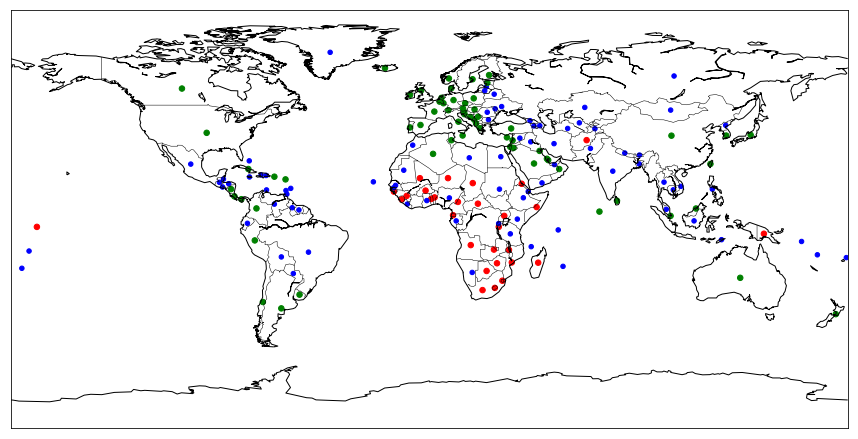

In [24]:
df_long_lat_lkp=pd.read_excel("lookups/long_lat.xlsx")
df_country_coordinates = pd.merge(df_long_lat_lkp, df_life_gdp_corr, on='country', how='inner')
fn_draw_world_by_measure(df_country_coordinates, 2016, 'life_exp_num')

One can observe high density of green color in Europe, North America, Australia and certain countries in SE Asia. Meanwhile Africa is primarily covered in red. This logically brings us to the conclusion that longevity can be related to economic development and well-being. This map shows the latest known state but let's see how this measure changed in the 19th and 20th centuries.

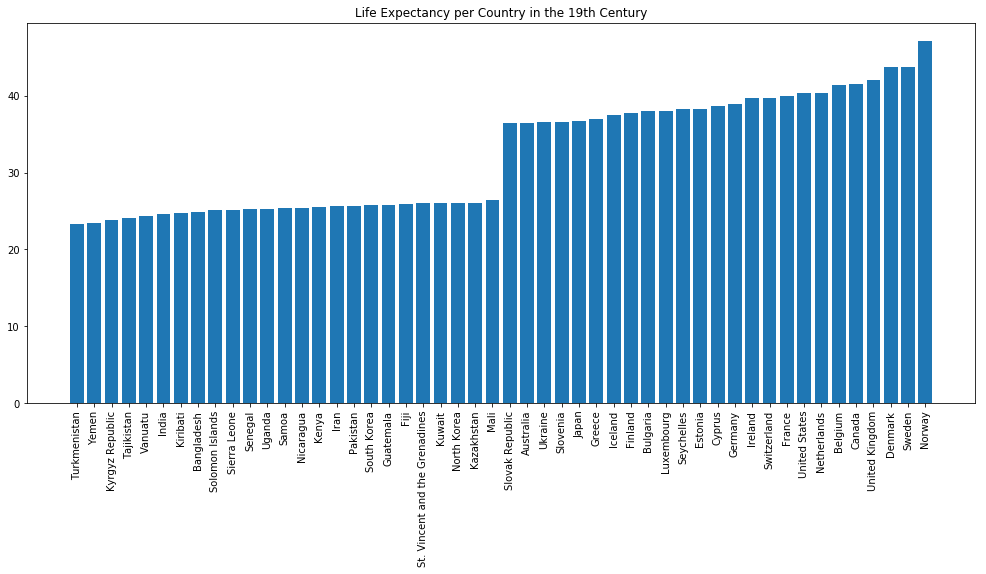

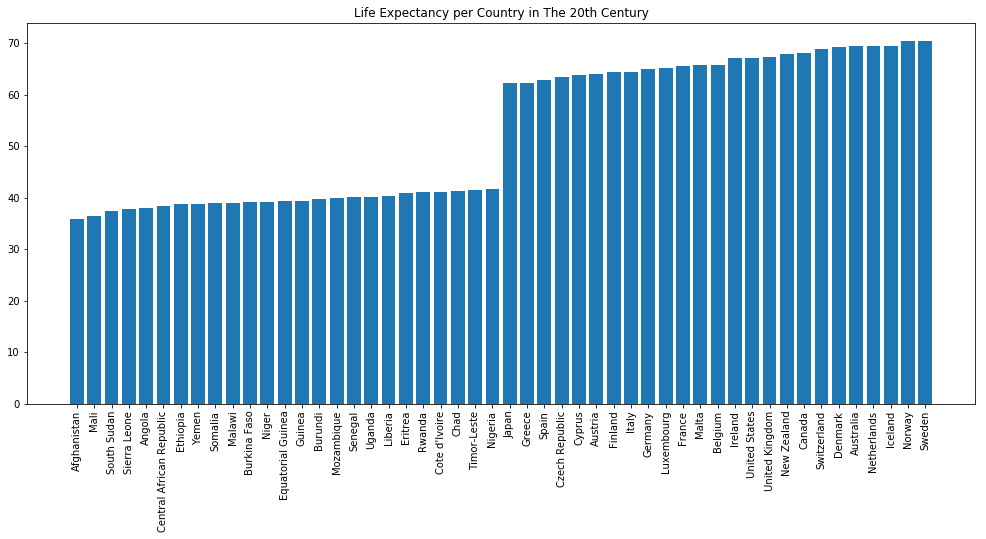

In [25]:
df_life_gdp_corr_before=df_life_gdp_corr[df_life_gdp_corr["year"]<1901]
df_life_gdp_corr_after=df_life_gdp_corr[df_life_gdp_corr["year"]>1900]
fn_plot_measure_by_countries(df_life_gdp_corr_before, "life_exp_num", "Life Expectancy per Country in the 19th Century")
fn_plot_measure_by_countries(df_life_gdp_corr_after, "life_exp_num", "Life Expectancy per Country in The 20th Century")

This drill down to country level is well aligned with what we saw on the map with Europe and North America leading the pack in both centuries. An interesting fact is that Bulgaria is ranked among the favorites in 19th century but unfortunately falls behind from the chart in the 20th. Now let's put this data on a plot and see the impact of time for a sample of trailing and leading countries. 

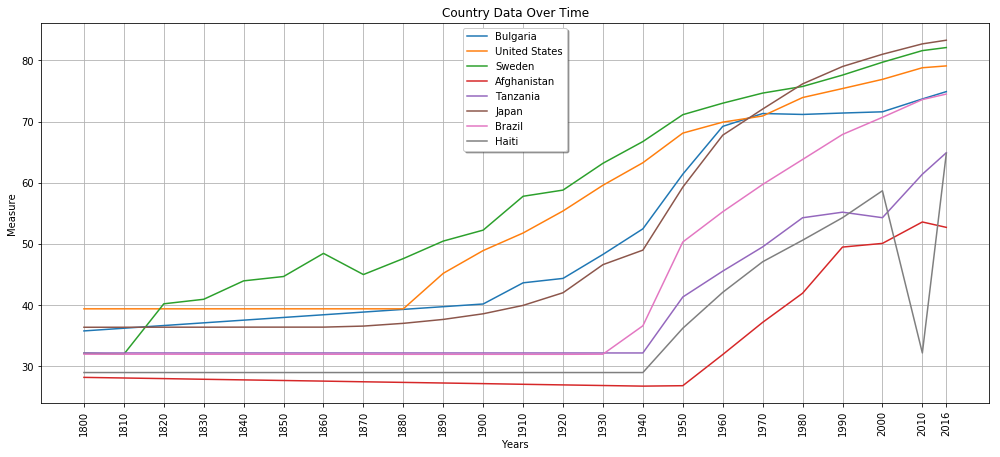

In [26]:
a_print_years=[1800,1810,1820,1830,1840,1850,1860,1870,1880,1890,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,2016]
fn_plot_countries_measure_per_year(df_life_gdp_corr, ['Bulgaria', 'United States', 'Sweden','Afghanistan','Tanzania','Japan','Brazil','Haiti'],a_print_years, 'life_exp_num')


One can easily spot a couple of patterns. The longevity starts to rise between 1880 and 1930 which is the period of massive industrialization in the world with USA, Europe and Asia leading the pack. In 2016 top 3 contrives (on the chart) are the ones with highest economic growth in the century (figuratively, not statistically). Meanwhile less developed countries would not rise above 70 years of life expectancy at birth. An interesting case is Haiti where the environmental disaster around 2010 reduced the average longevity in half, a striking reminder about the power of nature. Let us try to prove the assumption and calculate the correlation between economic development (using the GDP per Capita indicator) and longevity (using the Life Expectancy target measure). 

In [27]:
fn_calculate_correlation_between_two_features(df_life_gdp_corr, 'life_exp_num', 'gdp_amt')

Significant Positive Correlation: 0.575


The significant positive correlation between these two features explains the graphs and proves the major hypothesis that GDP can be used as a good indicator for longevity. 

### 2.5.2. Data Visualization and Analytics - Two-Year Datasets Batch

Now that we have proved the first major hypothesis let us focus on some of the other input variables and this time correlate them both to Life Expectancy and Under 5 Years Mortality. Let us calculate the correlation between these variables and plot them in a matrix for easier visual access. In the analysis we shall focus on the impact of input variables against the target measures (Under 5 Mortality Rate and Life Expectancy). 

In [28]:
df_two_years_batch.corr()

,water_withdrawal_num,agro_gdp_amt,ind_gdp_amt,services_gdp_amt,suicide_num,under5_mortality_num,life_exp_num
water_withdrawal_num,1.000000,-0.083751,0.181354,-0.077304,0.166258,-0.245803,0.212336
agro_gdp_amt,-0.083751,1.000000,-0.390114,-0.602216,-0.100444,0.717059,-0.608776
ind_gdp_amt,0.181354,-0.390114,1.000000,-0.499153,0.027317,-0.107725,0.046506
services_gdp_amt,-0.077304,-0.602216,-0.499153,1.000000,0.073187,-0.582382,0.531757
suicide_num,0.166258,-0.100444,0.027317,0.073187,1.000000,-0.137620,0.017632
under5_mortality_num,-0.245803,0.717059,-0.107725,-0.582382,-0.137620,1.000000,-0.877297
life_exp_num,0.212336,-0.608776,0.046506,0.531757,0.017632,-0.877297,1.000000


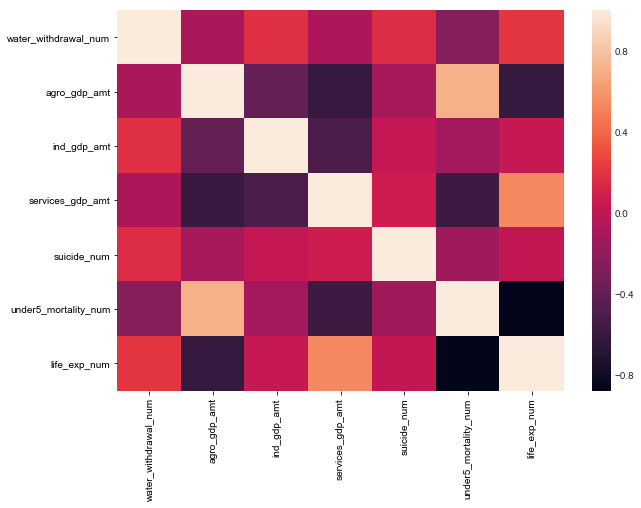

In [29]:
fn_plot_correlation_matrix(df_two_years_batch)

Let us take a step back and explain the principles behind this coefficients.

In statistics, the correlation coefficient r measures the strength and direction of a linear relationship between two variables on a scatterplot. Pearson's correlation coefficient when applied to a population is commonly represented by the Greek letter $ρ$ (rho) and may be referred to as the population correlation coefficient or the population Pearson correlation coefficient. The formula for $ρ$ is:

${\displaystyle \rho _{X,Y}={\frac {\operatorname {cov} (X,Y)}{\sigma _{X}\sigma _{Y}}}} \rho _{X,Y}$
where:
* ${\displaystyle \operatorname {cov}}$ is the covariance
* ${\displaystyle \sigma _{X}}$ is the standard deviation of ${\displaystyle X}$
* ${\displaystyle \sigma _{Y}}$  is the standard deviation of ${\displaystyle Y}$ 

The value of $ρ$ is always between $+1$ and $–1$. To interpret its value, see which of the following values your correlation $ρ$ is closest to:

* Exactly $–1$. A perfect downhill (negative) linear relationship
* $–0.70$ A strong downhill (negative) linear relationship
* $–0.50$ A moderate downhill (negative) relationship
* $–0.30$ A weak downhill (negative) linear relationship
* $0$ No linear relationship
* $+0.30$ A weak uphill (positive) linear relationship
* $+0.50$ A moderate uphill (positive) relationship
* $+0.70$ A strong uphill (positive) linear relationship
* Exactly $+1$ A perfect uphill (positive) linear relationship

Source: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

Now that we know the ranges for each correlation category we can identify the following:
* The [Suicide rate] is a weak connection towards understanding longevity and low child mortality rate. We may consider this more of a local social phenomenon rather than actual global indicator for health and wellbeing. Expected.
* The [Size of Industry as part of GDP] is in weak relationship. This gives an interesting insight that heavy production does not necessary impact positively towards the health of the nation (possibly related to pollution and environment). 
* The [Water Withdrawal] levels are weak correlated as well. This comes as a surprise considering the media nurtured image of poor kids in Africa carrying water home from large distances. 
* This brings to [Services] and [Agriculture] variables and their moderate to strong correlation towards our health target measures. The Life Expenditure seems positively correlated in countries that base their economy on Services (normally developed countries) and negatively correlated in countries that base their economy primarily on Agriculture (normally under-developed countries).

Last but not least these observations are in full alignment between the 2 target measures. This is perfectly expected considering the common sense fact that Life Expectancy and Under 5 Years Mortality Rate are strong negatively correlated meaning that countries with long life expectancy will have low values for the other measure.

### 2.5.3. Data Visualization and Analytics - Ten-Year Datasets Batch

We shall follow same analytical path towards the last Economics datasets batch as well. Let us investigate the correlation between datasets that we explored for a period of 10 years in the 21st century. 

In [30]:
df_ten_years_batch.corr()

,health_spending_pct,emissions_amt,electricity_usage_amt,urban_population_pct,coal_usage_amt,under5_mortality_num,life_exp_num
health_spending_pct,1.000000,0.541870,0.600755,0.518278,0.344821,-0.566071,0.566001
emissions_amt,0.541870,1.000000,0.676213,0.474020,0.760706,-0.449107,0.353715
electricity_usage_amt,0.600755,0.676213,1.000000,0.519253,0.348076,-0.524467,0.540918
urban_population_pct,0.518278,0.474020,0.519253,1.000000,0.231712,-0.668430,0.620993
coal_usage_amt,0.344821,0.760706,0.348076,0.231712,1.000000,-0.194512,0.047657
under5_mortality_num,-0.566071,-0.449107,-0.524467,-0.668430,-0.194512,1.000000,-0.828624
life_exp_num,0.566001,0.353715,0.540918,0.620993,0.047657,-0.828624,1.000000


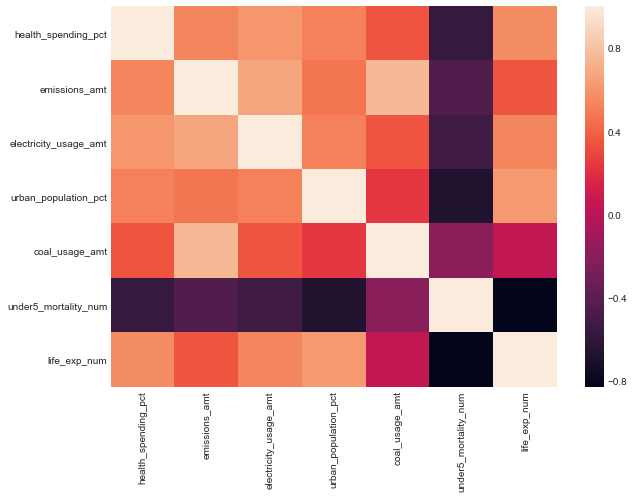

In [31]:
fn_plot_correlation_matrix(df_ten_years_batch)

See how much lighter is this matrix? The correlation matrix kicks in conveniently to visualize the correlations from our last Economics Dataset. One can observe the following dependencies:
* [Coal Usage] correlation factor is low. Humanity tends to recognize air pollution and global warming but the environmental changes cannot be observed directly. A convenient fact for populists in media. 
* [Urbanization], [Electricity Usage] and [Healthcare spending] are visibly strong correlations, along with [CO2 Emissions]. All these factors are usually tied to developed countries supporting the overall hypothesis that GDP is positively tied towards Life Expectancy. 

# 3. Food and Drink

## 3.1. Food and Drink - Chapter Introduction

Let us refine our question: **How do our choices in food and drinks affect our overall health?**

The alternative view to longevity focuses on various factors related to the eating habits of population. 
* (#2001) Alcohol Consumption, 
* (#2002) Blood Pressure, 
* (#2003) Body Mass Index, 
* (#2004) Cholesterol, 
* (#2005) Calorie Intake and 
* (#2006) Sugar Intake.

These variables shall be correlated towards `[Life Expectancy]` target measure from the previous chapter. 

## 3.2. Food and Drink - Data Acquisition

One can follow the established practice to load the datasets, rename the opening column where needed.

In [32]:
#Loading the orignal datasets
fn_log_time("Datasets Loading", "started")

df_alcohol_consumption_src=pd.read_excel("2. FoodAndDrink/alcohol_consumption.xlsx", sheet_name="Data")
df_alcohol_consumption_src=df_alcohol_consumption_src.reset_index(level=0)
df_alcohol_consumption_src=df_alcohol_consumption_src.rename(columns = {'index':'alcohol_consumption'})
print(fn_get_df_shape(df_alcohol_consumption_src))

df_blood_pressure_female_src=pd.read_excel("2. FoodAndDrink/blood_pressure_female.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_blood_pressure_female_src))

df_blood_pressure_male_src=pd.read_excel("2. FoodAndDrink/blood_pressure_male.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_blood_pressure_male_src))

df_bmi_female_src=pd.read_excel("2. FoodAndDrink/bmi_female.xlsx", sheet_name="Data")
df_bmi_female_src=df_bmi_female_src.rename(columns = {'Country':'bmi_female'})
print(fn_get_df_shape(df_bmi_female_src))

df_bmi_male_src=pd.read_excel("2. FoodAndDrink/bmi_male.xlsx", sheet_name="Data")
df_bmi_male_src=df_bmi_male_src.rename(columns = {'Country':'bmi_male'})
print(fn_get_df_shape(df_bmi_male_src))

df_cholesterol_female_src=pd.read_excel("2. FoodAndDrink/cholesterol_female.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_cholesterol_female_src))

df_cholesterol_male_src=pd.read_excel("2. FoodAndDrink/cholesterol_male.xlsx", sheet_name="Data")
print(fn_get_df_shape(df_cholesterol_male_src))

df_food_consumption_src=pd.read_excel("2. FoodAndDrink/food_consumption.xlsx", sheet_name="Data")
df_food_consumption_src=df_food_consumption_src.reset_index(level=0)
df_food_consumption_src=df_food_consumption_src.rename(columns = {'index':'food_consumption'})
print(fn_get_df_shape(df_food_consumption_src))

df_sugar_consumption_src=pd.read_excel("2. FoodAndDrink/sugar_consumption.xlsx", sheet_name="Data")
df_sugar_consumption_src=df_sugar_consumption_src.reset_index(level=0)
df_sugar_consumption_src=df_sugar_consumption_src.rename(columns = {'index':'sugar_consumption'})
print(fn_get_df_shape(df_sugar_consumption_src))

fn_log_time("Datasets Loading", "ended successfully")

..:: Datasets Loading started on 11 Feb 2018 16:29:32 ::..
189 observations loaded on 25 features for metric 'alcohol_consumption'
199 observations loaded on 30 features for metric 'SBP female (mm Hg), age standardized mean'
199 observations loaded on 30 features for metric 'SBP male (mm Hg), age standardized mean'
199 observations loaded on 30 features for metric 'bmi_female'
199 observations loaded on 30 features for metric 'bmi_male'
199 observations loaded on 30 features for metric 'TC female (mmol/L), age standardized mean'
199 observations loaded on 30 features for metric 'TC male (mmol/L), age standardized mean'
259 observations loaded on 48 features for metric 'food_consumption'
259 observations loaded on 45 features for metric 'sugar_consumption'
..:: Datasets Loading ended successfully on 11 Feb 2018 16:29:32 ::..


## 2.3. Food and Drink - Data Cleansing

Now that we have loaded the new datasets let us play and cleanse data and normalize the structure renaming columns and setting appropriate index. 

In [33]:
fn_log_time("Datasets Indexing", "started")
df_alcohol_consumption_src_wrk =fn_rename_and_set_index(df_alcohol_consumption_src)
df_blood_pressure_female_src_wrk=fn_rename_and_set_index(df_blood_pressure_female_src)
df_blood_pressure_male_src_wrk=fn_rename_and_set_index(df_blood_pressure_male_src)
df_bmi_female_src_wrk=fn_rename_and_set_index(df_bmi_female_src)
df_bmi_male_src_wrk=fn_rename_and_set_index(df_bmi_male_src)
df_cholesterol_female_src_wrk=fn_rename_and_set_index(df_cholesterol_female_src)
df_cholesterol_male_src_wrk=fn_rename_and_set_index(df_cholesterol_male_src)
df_food_consumption_src_wrk=fn_rename_and_set_index(df_food_consumption_src)
df_sugar_consumption_src_wrk=fn_rename_and_set_index(df_sugar_consumption_src)
fn_log_time("Datasets Indexing", "ended successfully")

..:: Datasets Indexing started on 11 Feb 2018 16:29:32 ::..
..:: Datasets Indexing ended successfully on 11 Feb 2018 16:29:32 ::..


Checking datatypes for the columns to avoid issues with aggregation down the road.

In [34]:
fn_check_float_dtypes(df_alcohol_consumption_src_wrk,'df_alcohol_consumption_src')
fn_check_float_dtypes(df_blood_pressure_female_src_wrk,'df_blood_pressure_female_src')
fn_check_float_dtypes(df_blood_pressure_male_src_wrk,'df_blood_pressure_male_src')
fn_check_float_dtypes(df_bmi_female_src_wrk,'df_bmi_female_src')
fn_check_float_dtypes(df_bmi_male_src_wrk,'df_bmi_male_src')
fn_check_float_dtypes(df_cholesterol_female_src_wrk,'df_cholesterol_female_src')
fn_check_float_dtypes(df_cholesterol_male_src_wrk,'df_cholesterol_male_src')
fn_check_float_dtypes(df_food_consumption_src_wrk,'df_food_consumption_src')
fn_check_float_dtypes(df_sugar_consumption_src_wrk,'df_sugar_consumption_src')

df_alcohol_consumption_src dataset [float64] data format confirmed. STATUS: OK.
df_blood_pressure_female_src dataset [float64] data format confirmed. STATUS: OK.
df_blood_pressure_male_src dataset [float64] data format confirmed. STATUS: OK.
df_bmi_female_src dataset [float64] data format confirmed. STATUS: OK.
df_bmi_male_src dataset [float64] data format confirmed. STATUS: OK.
df_cholesterol_female_src dataset [float64] data format confirmed. STATUS: OK.
df_cholesterol_male_src dataset [float64] data format confirmed. STATUS: OK.
df_food_consumption_src dataset [float64] data format confirmed. STATUS: OK.
df_sugar_consumption_src dataset [float64] data format confirmed. STATUS: OK.


Certain column name types are string and others are int. Let us make sure that we make them consistent.

In [35]:
df_alcohol_consumption_src_wrk=fn_convert_column_types_to_int(df_alcohol_consumption_src_wrk)
df_blood_pressure_female_src_wrk=fn_convert_column_types_to_int(df_blood_pressure_female_src_wrk)
df_blood_pressure_male_src_wrk=fn_convert_column_types_to_int(df_blood_pressure_male_src_wrk)
df_bmi_female_src_wrk=fn_convert_column_types_to_int(df_bmi_female_src_wrk)
df_bmi_male_src_wrk=fn_convert_column_types_to_int(df_bmi_male_src_wrk)
df_cholesterol_female_src_wrk=fn_convert_column_types_to_int(df_cholesterol_female_src_wrk)
df_cholesterol_male_src_wrk=fn_convert_column_types_to_int(df_cholesterol_male_src_wrk)
df_food_consumption_src_wrk=fn_convert_column_types_to_int(df_food_consumption_src_wrk)
df_sugar_consumption_src_wrk=fn_convert_column_types_to_int(df_sugar_consumption_src_wrk)

Now let us remove empty rows and columns of data.

In [36]:
fn_log_time("Initial Null Data Cleansing", "started")
df_alcohol_consumption_src_wrk=df_alcohol_consumption_src_wrk.dropna(axis=0, how='all')
df_alcohol_consumption_src_wrk=df_alcohol_consumption_src_wrk.dropna(axis=1, how='all')

df_blood_pressure_female_src_wrk=df_blood_pressure_female_src_wrk.dropna(axis=0, how='all')
df_blood_pressure_female_src_wrk=df_blood_pressure_female_src_wrk.dropna(axis=1, how='all')

df_blood_pressure_male_src_wrk=df_blood_pressure_male_src_wrk.dropna(axis=0, how='all')
df_blood_pressure_male_src_wrk=df_blood_pressure_male_src_wrk.dropna(axis=1, how='all')

df_bmi_female_src_wrk=df_bmi_female_src_wrk.dropna(axis=0, how='all')
df_bmi_female_src_wrk=df_bmi_female_src_wrk.dropna(axis=1, how='all')

df_bmi_male_src_wrk=df_bmi_male_src_wrk.dropna(axis=0, how='all')
df_bmi_male_src_wrk=df_bmi_male_src_wrk.dropna(axis=1, how='all')

df_cholesterol_female_src_wrk=df_cholesterol_female_src_wrk.dropna(axis=0, how='all')
df_cholesterol_female_src_wrk=df_cholesterol_female_src_wrk.dropna(axis=1, how='all')

df_cholesterol_male_src_wrk=df_cholesterol_male_src_wrk.dropna(axis=0, how='all')
df_cholesterol_male_src_wrk=df_cholesterol_male_src_wrk.dropna(axis=1, how='all')

df_food_consumption_src_wrk=df_food_consumption_src_wrk.dropna(axis=0, how='all')
df_food_consumption_src_wrk=df_food_consumption_src_wrk.dropna(axis=1, how='all')

df_sugar_consumption_src_wrk=df_sugar_consumption_src_wrk.dropna(axis=0, how='all')
df_sugar_consumption_src_wrk=df_sugar_consumption_src_wrk.dropna(axis=1, how='all')
fn_log_time("Initial Null Data Cleansing", "ended successfully")

..:: Initial Null Data Cleansing started on 11 Feb 2018 16:29:32 ::..
..:: Initial Null Data Cleansing ended successfully on 11 Feb 2018 16:29:32 ::..


Here is a sanity check to see the available period range for each of the datasets. 

In [37]:
fn_get_dataset_years_range(df_alcohol_consumption_src_wrk,'df_alcohol_consumption_src_wrk')
fn_get_dataset_years_range(df_blood_pressure_female_src_wrk,'df_blood_pressure_female_src_wrk')
fn_get_dataset_years_range(df_blood_pressure_male_src_wrk,'df_blood_pressure_male_src_wrk')
fn_get_dataset_years_range(df_bmi_female_src_wrk,'df_bmi_female_src_wrk')
fn_get_dataset_years_range(df_bmi_male_src_wrk,'df_bmi_male_src_wrk')
fn_get_dataset_years_range(df_cholesterol_female_src_wrk,'df_cholesterol_female_src_wrk')
fn_get_dataset_years_range(df_cholesterol_male_src_wrk,'df_cholesterol_male_src_wrk')
fn_get_dataset_years_range(df_food_consumption_src_wrk,'df_food_consumption_src_wrk')
fn_get_dataset_years_range(df_sugar_consumption_src_wrk,'df_sugar_consumption_src_wrk')

df_alcohol_consumption_src_wrk : 1985 - 2008
df_blood_pressure_female_src_wrk : 1980 - 2008
df_blood_pressure_male_src_wrk : 1980 - 2008
df_bmi_female_src_wrk : 1980 - 2008
df_bmi_male_src_wrk : 1980 - 2008
df_cholesterol_female_src_wrk : 1980 - 2008
df_cholesterol_male_src_wrk : 1980 - 2008
df_food_consumption_src_wrk : 1961 - 2007
df_sugar_consumption_src_wrk : 1961 - 2004


Having checked for years data of range we shall check for sanity in country data as well. There are three options to decide from:
* If percentage of missing data for a country is too high, it is fine to remove this country data
* If percentage is relatively low we can fill null values on case per case basis

In [38]:
print("1. Cleansing Alcohol Consumption Dataset for missing country data:")
ss_alcohol_consumption_with_nulls=fn_identify_countries_with_nulls(df_alcohol_consumption_src_wrk)
print("Number of countries with missing data:", len(ss_alcohol_consumption_with_nulls))
print("*** Too many missing data points. df_alcohol_consumption_src_wrk dataset to be discarded from this correlation.")

print("2. Cleansing Blood Pressure Female dataset for missing country data:")
ss_blood_pressure_female_with_nulls=fn_identify_countries_with_nulls(df_blood_pressure_female_src_wrk )
print(ss_blood_pressure_female_with_nulls)

print("3. Cleansing Blood Pressure Male dataset for missing country data:")
ss_blood_pressure_male_with_nulls=fn_identify_countries_with_nulls(df_blood_pressure_male_src_wrk)
print(ss_blood_pressure_male_with_nulls)

print("4. Cleansing BMI Female dataset for missing country data:")
ss_bmi_female_with_nulls=fn_identify_countries_with_nulls(df_bmi_female_src_wrk )
print(ss_bmi_female_with_nulls)

print("5. Cleansing BMI Male dataset for missing country data:")
ss_bmi_male_with_nulls=fn_identify_countries_with_nulls(df_bmi_male_src_wrk  )
print(ss_bmi_male_with_nulls)

print("6. Cleansing Cholesterol Female dataset for missing country data:")
ss_cholesterol_female_with_nulls=fn_identify_countries_with_nulls(df_cholesterol_female_src_wrk)
print(ss_cholesterol_female_with_nulls)

print("7. Cleansing Cholesterol Male dataset for missing country data:")
ss_cholesterol_male_with_nulls=fn_identify_countries_with_nulls(df_cholesterol_male_src_wrk)
print(ss_cholesterol_male_with_nulls)

print("8. Cleansing Food Consumption dataset for missing country data:")
ss_food_consumption_with_nulls=fn_identify_countries_with_nulls(df_food_consumption_src_wrk)
print(ss_food_consumption_with_nulls)
df_food_consumption_src_wrk=df_food_consumption_src_wrk.drop(ss_food_consumption_with_nulls.index.tolist(),axis=0)
print("*** The following countries have been deleted from the dataset:", ss_food_consumption_with_nulls.index.tolist())
print("---------------------")

print("9. Cleansing Sugar Consumption dataset for missing country data:")
ss_sugar_consumption_with_nulls=fn_identify_countries_with_nulls(df_sugar_consumption_src_wrk)
print(ss_sugar_consumption_with_nulls)
df_sugar_consumption_src_wrk=df_sugar_consumption_src_wrk.drop(ss_sugar_consumption_with_nulls.index.tolist(),axis=0)
print("*** The following countries have been deleted from the dataset:", ss_sugar_consumption_with_nulls.index.tolist())

1. Cleansing Alcohol Consumption Dataset for missing country data:
Number of countries with missing data: 189
*** Too many missing data points. df_alcohol_consumption_src_wrk dataset to be discarded from this correlation.
2. Cleansing Blood Pressure Female dataset for missing country data:
No missing values for countries in this dataset.
3. Cleansing Blood Pressure Male dataset for missing country data:
No missing values for countries in this dataset.
4. Cleansing BMI Female dataset for missing country data:
No missing values for countries in this dataset.
5. Cleansing BMI Male dataset for missing country data:
No missing values for countries in this dataset.
6. Cleansing Cholesterol Female dataset for missing country data:
No missing values for countries in this dataset.
7. Cleansing Cholesterol Male dataset for missing country data:
No missing values for countries in this dataset.
8. Cleansing Food Consumption dataset for missing country data:
country
Montenegro                0.9574

## 3.4. Food and Drink - Data Modelling

Now that we have verified that datasets are clean we shall proceed towards unpivoting the datasets to building the composite primary key of ['country','year'].

In [39]:
#Unpivoting the datasets
df_blood_pressure_female_melt=fn_unpivot_years(df_blood_pressure_female_src_wrk, "blood_pressure_female_amt")
df_blood_pressure_male_melt=fn_unpivot_years(df_blood_pressure_male_src_wrk, "blood_pressure_male_amt")
df_bmi_female_melt=fn_unpivot_years(df_bmi_female_src_wrk, "bmi_female_amt")
df_bmi_male_melt=fn_unpivot_years(df_bmi_male_src_wrk, "bmi_male_amt")
df_cholesterol_female_melt=fn_unpivot_years(df_cholesterol_female_src_wrk, "cholesterol_female_amt")
df_cholesterol_male_melt=fn_unpivot_years(df_cholesterol_male_src_wrk, "cholesterol_male_amt")
df_food_consumption_melt=fn_unpivot_years(df_food_consumption_src_wrk, "food_consumption_amt")
df_sugar_consumption_melt=fn_unpivot_years(df_sugar_consumption_src_wrk, "sugar_consumption_amt")

Some of these datasets show data per gender which is not a requirement for us considering that the target measure we use (Life Expectancy) is not split on gender either. Let us merge these datasets by averaging the values from both gender-split datasets.

In [40]:
#Joining the Male/Female datasets for consolidation
df_blood_pressure_female_male=pd.merge(df_blood_pressure_female_melt,df_blood_pressure_male_melt,on=["country","year"], how="inner")
df_blood_pressure_female_male['blood_pressure_amt']=(df_blood_pressure_female_male['blood_pressure_female_amt']+df_blood_pressure_female_male['blood_pressure_male_amt'])/2
df_blood_pressure_female_male=df_blood_pressure_female_male.drop(["blood_pressure_female_amt","blood_pressure_male_amt"],axis=1)
df_bmi_female_male=pd.merge(df_bmi_female_melt,df_bmi_male_melt,on=["country","year"], how="inner")
df_bmi_female_male['bmi_amt']=(df_bmi_female_male['bmi_female_amt']+df_bmi_female_male['bmi_male_amt'])/2
df_bmi_female_male=df_bmi_female_male.drop(["bmi_female_amt","bmi_male_amt"],axis=1)
df_cholesterol_female_male=pd.merge(df_cholesterol_female_melt,df_cholesterol_male_melt,on=["country","year"], how="inner")
df_cholesterol_female_male['cholesterol_amt']=(df_cholesterol_female_male['cholesterol_female_amt']+df_cholesterol_female_male['cholesterol_male_amt'])/2
df_cholesterol_female_male=df_cholesterol_female_male.drop(["cholesterol_female_amt","cholesterol_male_amt"], axis=1)

Now that we have the datasets normalized to a common model, let us join the datasets into a single clean sheet ready for downstream visualizations and analytics.

In [41]:
#Joining the datasets for further correlation investigation:
df_corr4=pd.merge(df_blood_pressure_female_male,df_bmi_female_male,on=["country","year"], how="inner")
df_corr4=pd.merge(df_corr4,df_cholesterol_female_male,on=["country","year"], how="inner")
df_corr4=pd.merge(df_corr4,df_food_consumption_melt,on=["country","year"], how="inner")
df_corr4=pd.merge(df_corr4,df_sugar_consumption_melt,on=["country","year"], how="inner")
df_food_drink_batch=pd.merge(df_corr4,df_life_melt_wrk,on=["country","year"], how="inner")

## 3.5. Food and Drink - Data Visualization and Analytics

Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the other is considered to be a dependent variable. For example, a modeler might want to relate the weights of individuals to their heights using a linear regression model. Before attempting to fit a linear model to observed data, a modeler should first determine whether or not there is a relationship between the variables of interest. This does not necessarily imply that one variable causes the other (for example, higher SAT scores do not cause higher college grades), but that there is some significant association between the two variables. 

A scatterplot can be a helpful tool in determining the strength of the relationship between two variables. If the scatterplot doesn’t indicate there’s at least somewhat of a linear relationship, the correlation doesn’t mean much. Why measure the amount of linear relationship if there isn’t enough of one to speak of? However, you can take the idea of no linear relationship two ways: 
* If no relationship at all exists, calculating the correlation doesn’t make sense because correlation only applies to linear relationships; and 
* If a strong relationship exists but it’s not linear, the correlation may be misleading, because in some cases a strong curved relationship exists. That’s why it’s critical to examine the scatterplot first.

Source: http://www.dummies.com/education/math/statistics/how-to-interpret-a-correlation-coefficient-r/

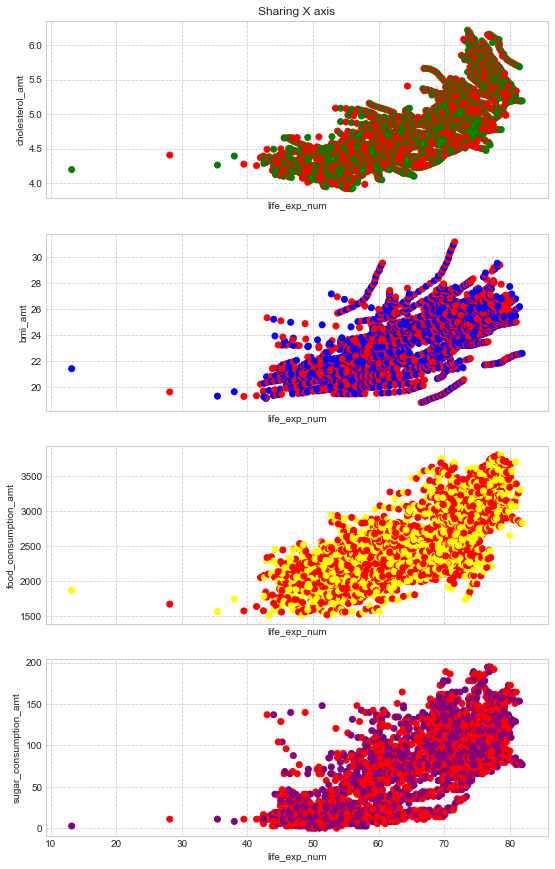

In [42]:
x = df_food_drink_batch['life_exp_num']
y = df_food_drink_batch['cholesterol_amt']
z = df_food_drink_batch['bmi_amt']
l = df_food_drink_batch['food_consumption_amt']
m = df_food_drink_batch['sugar_consumption_amt']

colors1= ['red', 'green']
colors2= ['red', 'blue']
colors3= ['red', 'yellow']
colors4= ['red', 'purple']

f, axarr = plt.subplots(4, sharex=True,figsize=(9, 15))

axarr[0].set_title('Sharing X axis')

axarr[0].scatter(x, y,c=colors1)       
axarr[0].set_xlabel('life_exp_num')
axarr[0].set_ylabel('cholesterol_amt')

axarr[1].scatter(x, z, c=colors2)
axarr[1].set_xlabel('life_exp_num')
axarr[1].set_ylabel('bmi_amt')

axarr[2].scatter(x, l, c=colors3)
axarr[2].set_xlabel('life_exp_num')
axarr[2].set_ylabel('food_consumption_amt')

axarr[3].scatter(x, m, c=colors4)
axarr[3].set_xlabel('life_exp_num')
axarr[3].set_ylabel('sugar_consumption_amt')

plt.show()

Scatters prove our assumption that certain correlation may be observed. Let us calculate and plot it. 

In [43]:
df_food_drink_batch.corr()

,blood_pressure_amt,bmi_amt,cholesterol_amt,food_consumption_amt,sugar_consumption_amt,life_exp_num
blood_pressure_amt,1.000000,0.127146,0.310081,0.241824,0.075459,0.033488
bmi_amt,0.127146,1.000000,0.640266,0.705004,0.710821,0.717587
cholesterol_amt,0.310081,0.640266,1.000000,0.767248,0.693286,0.765785
food_consumption_amt,0.241824,0.705004,0.767248,1.000000,0.648697,0.751301
sugar_consumption_amt,0.075459,0.710821,0.693286,0.648697,1.000000,0.747998
life_exp_num,0.033488,0.717587,0.765785,0.751301,0.747998,1.000000


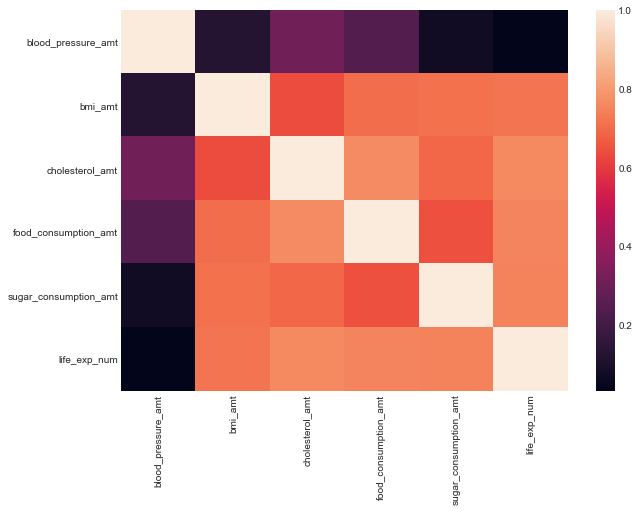

In [44]:
fn_plot_correlation_matrix(df_food_drink_batch)

A linear regression line has an equation of the form $y = a + b*x$, where $x$ is the explanatory variable and $y$ is the dependent variable. The slope of the line is b, and a is the intercept (the value of $y$ when $x = 0$).

Derived Target Formula: y = 0.08491988 * x + 54.84377905


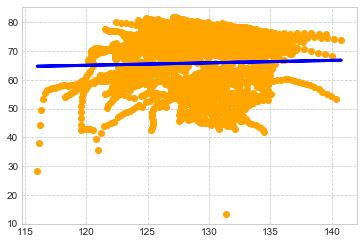

In [45]:
fn_plot_linear_regression(df_food_drink_batch, 'blood_pressure_amt', 'life_exp_num')

Derived Target Formula: y = 3.12139913 * x + -8.36467731


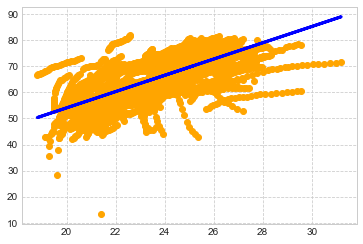

In [46]:
fn_plot_linear_regression(df_food_drink_batch, 'bmi_amt', 'life_exp_num')

Derived Target Formula: y = 14.87921970 * x + -5.80301322


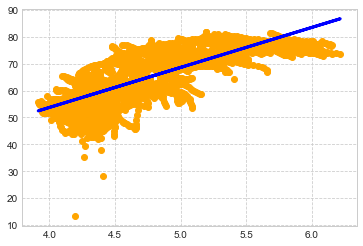

In [47]:
fn_plot_linear_regression(df_food_drink_batch, 'cholesterol_amt', 'life_exp_num')

Derived Target Formula: y = 0.01365825 * x + 30.40168166


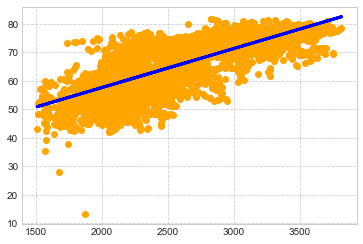

In [48]:
fn_plot_linear_regression(df_food_drink_batch, 'food_consumption_amt', 'life_exp_num')

Derived Target Formula: y = 0.15640048 * x + 53.54121910


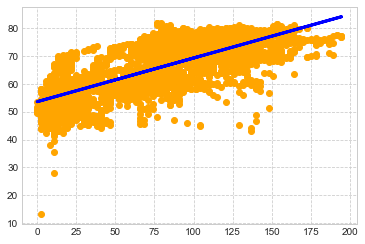

In [49]:
fn_plot_linear_regression(df_food_drink_batch, 'sugar_consumption_amt', 'life_exp_num')

One can conclude the following observations:
* **(#2001) Alcohol Consumption,**
<br>Out of Scope
* **(#2002) Blood Pressure**
<br>Low correlation - Life Expectancy is not well correlated to Blood Pressure.
* **(#2003) Body Mass Index** 
<br>Strong positive correlation -  Life expectancy is strongly related to BMI scores. 
* **(#2004) Cholesterol**
<br>Stong positive correlation - Life expectancy is strongly related to Cholesterol levels. 
* **(#2005) Calorie Intake**
<br>Strong positive correlation - Life expectancy is strongly related to Calorie Intake levels. 
* **(#2006) Sugar Intake**
<br>Strong positive correlation - Life expectancy is strongly related to Sugar Intake 

# 4. ATUS US Health Data

## 4.1. US Health Data - Introduction

The ATUS Eating & Health (EH) Module was fielded from 2006 to 2008 and again in 2014 to 2016. The EH Module data files contain additional information related to eating, meal preparation and health. The EH Respondent file contains information about EH respondents, including general health and body mass index. As opposed to previous datasets format, this survey is covering respondents from a single country (United States) and is not subject to analysis over team (year over year). There are 37 variables in total with the following causing interest to us based on the broader question of variables impacting health and longevity:
* (#3001) Monthly Household Income - descriptive variable, also related to GDP from chapter 1
* (#3002) Income vs Poverty - descriptive variable, also related to GDP from chapter 1
* (#3003) Soft Drink Consumption - habitual variable to examine
* (#3004) Physical Activity - habitual variable to examine
* (#3005) Fast Food Consumption - habitual variable to examine
* (#3006) Height/Weight - habitual variables to examine
* (#3007) Meat Consumption - habitual variable to examine
* (#3008) Milk Consumption - habitual variable to examine 
* (#3009) Shopping Location of Choice - habitual variable to examine
* (#3010) BMI - habitual variable to examine

We shall relate all these against `(#0003) Health Status` target measure which relates to the broader topic of health and longevity. 

## 4.2. US Health Data - Data Acquisiton

Original source data file contains a number of columns that represent a single survey. We shall load the whole file for simplicity but effectively subset only the columns that we find directly relevant to the question at hand as introduced in previous subchapter. 

In [50]:
df_ehresp_us=pd.read_csv("3. US/ehresp_2014.csv")
df_ehresp_us=df_ehresp_us[['eeincome1','erincome','eudrink','eusoda','euexercise','eufastfdfrq','eufdsit','euhgt','euwgt','eumeat','eumilk','eusnap','eustreason', 'erbmi','eugenhth']]
df_ehresp_us.sample(1)

,eeincome1,erincome,eudrink,eusoda,euexercise,eufastfdfrq,eufdsit,euhgt,euwgt,eumeat,eumilk,eusnap,eustreason,erbmi,eugenhth
7085,1,1,1,1,1,1,1,64,155,-1,-1,2,-1,26.6,1


## 4.3. US Health Data - Data Cleansing

We see that the columns are coming with their source names. Let us standardize them to a meaningful wording:

In [51]:
df_ehresp_us=df_ehresp_us.rename(columns = {
                                          'eeincome1':'income_per_month',
                                          'erincome':'income_vs_poverty',
                                          'eudrink':'non_water_consum',
                                          'eusoda':'soft_beverages',
                                          'euexercise':'physical_activities',
                                          'eufastfdfrq':'fast_food_consum',
                                          'eufdsit':'food_accsess',
                                          'euhgt':'height',
                                          'euwgt':'weight',
                                          'eumeat':'meat_consum',
                                          'eumilk':'milk_consum',
                                          'eusnap':'food_stamp',
                                          'eustreason':'shopping_loc_drive',
                                          'erbmi':'body_mass_index',
                                          'eugenhth':'health_status'})
df_ehresp_us.sample(1)
# df_ehresp_us.columns

,income_per_month,income_vs_poverty,non_water_consum,soft_beverages,physical_activities,fast_food_consum,food_accsess,height,weight,meat_consum,milk_consum,food_stamp,shopping_loc_drive,body_mass_index,health_status
8823,1,1,1,2,2,2,1,63,125,1,2,2,-1,22.1,2


Let us find some metadata regarding the dataset we have on hand.

In [52]:
df_ehresp_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11212 entries, 0 to 11211
Data columns (total 15 columns):
income_per_month       11212 non-null int64
income_vs_poverty      11212 non-null int64
non_water_consum       11212 non-null int64
soft_beverages         11212 non-null int64
physical_activities    11212 non-null int64
fast_food_consum       11212 non-null int64
food_accsess           11212 non-null int64
height                 11212 non-null int64
weight                 11212 non-null int64
meat_consum            11212 non-null int64
milk_consum            11212 non-null int64
food_stamp             11212 non-null int64
shopping_loc_drive     11212 non-null int64
body_mass_index        11212 non-null float64
health_status          11212 non-null int64
dtypes: float64(1), int64(14)
memory usage: 1.3 MB


The dataset seems nice and tidy with no null values to handle. Within the dataset description documentation, however, one can see that each column comes with a pre-defined acceptable list of values. We shall be most cautious about our target measure: `health_status`. Let us define a lookup array with the valid values and push the dataset through. 

In [53]:
a_valid_entry = [1,2,3,4,5]
n_entries_before_cleansing=df_ehresp_us.shape[0]
df_ehresp_us=df_ehresp_us[df_ehresp_us['health_status'].isin(a_valid_entry)]
n_entries_after_cleansing=df_ehresp_us.shape[0]
print(n_entries_before_cleansing-n_entries_after_cleansing,"entries have been removed due to non-valid health status.",)

84 entries have been removed due to non-valid health status.


Just out of curiosity let us subset the whole dataset and see whether any perfect entry 

In [54]:
ds_income_per_month = [1,2,3]
ds_income_vs_poverty = [1,2,3,4,5]
ds_non_water_consum = [1,2]
ds_soft_beverages = [1,2]
ds_physical_activities = [1,2]
ds_food_accsess = [1,2,3]
ds_meat_consum = [1,2]
ds_milk_consum = [1,2]
ds_food_stamp = [1,2]
ds_shopping_loc_drive = [1,2,3,4,5,6]
df_ehresp_us_wrk=df_ehresp_us.copy()

df_ehresp_us_wrk.loc[(df_ehresp_us_wrk['height'] < 56)] = 56
df_ehresp_us_wrk.loc[(df_ehresp_us_wrk['height'] > 77)] = 77
df_ehresp_us_wrk.loc[(df_ehresp_us_wrk['weight']>-5) & (df_ehresp_us_wrk['weight']<98)] = 98
df_ehresp_us_wrk.loc[(df_ehresp_us_wrk['height'] > 340)] = 340

df_ehresp_us_valid_only = df_ehresp_us[(df_ehresp_us_wrk['income_per_month'].isin(ds_income_per_month)) & 
                               (df_ehresp_us_wrk['income_vs_poverty'].isin(ds_income_vs_poverty)) &
                               (df_ehresp_us_wrk['non_water_consum'].isin(ds_non_water_consum)) &
                              (df_ehresp_us_wrk['soft_beverages'].isin(ds_soft_beverages)) &
                              (df_ehresp_us_wrk['physical_activities'].isin(ds_physical_activities)) &
                              (df_ehresp_us_wrk['fast_food_consum']>=1) & (df_ehresp_us_wrk['fast_food_consum']<=95) &
                              (df_ehresp_us_wrk['food_accsess'].isin(ds_food_accsess)) &
                              (df_ehresp_us_wrk['height']>=56) & (df_ehresp_us_wrk['height']<=77) &
                              (df_ehresp_us_wrk['weight']==-5) & (df_ehresp_us_wrk['weight']>=98) & (df_ehresp_us_wrk['weight'] <= 340) &
                              (df_ehresp_us_wrk['meat_consum'].isin(ds_meat_consum)) & 
                              (df_ehresp_us_wrk['milk_consum'].isin(ds_milk_consum)) & 
                              (df_ehresp_us_wrk['food_stamp'].isin(ds_food_stamp)) & 
                              (df_ehresp_us_wrk['shopping_loc_drive'].isin(ds_shopping_loc_drive)) &
                              (df_ehresp_us_wrk['body_mass_index']>=0) & (df_ehresp_us_wrk['body_mass_index']<=200)
                                      ]

print (df_ehresp_us_valid_only.shape[0],"perfect entries.")

0 perfect entries.


That is an interesting observation that although data is present (no null values found) we shall still be cautious about its quality and integrity. In any case this is no showstopper for our analysis. All rows where `health status` is a valid value can contribute to examination of certain variable features. 

## 4.4. US Health Data - Data Modelling

Data seems in a proper format for downstream analysis. No additional effort required at this time.

## 4.5. US Health Data - Data Visualization & Analysis

Let us first have a broad check over the health status of respondents and align it with our expectations from Unites States data from chapter 1. 

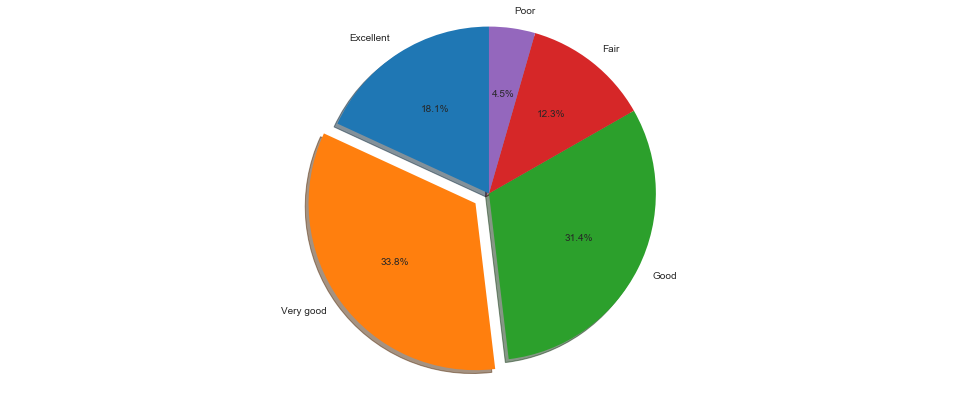

In [55]:
health_status_1=df_ehresp_us[df_ehresp_us['health_status']==1]
health_status_1_sum = health_status_1.health_status.count()
health_status_2=df_ehresp_us[df_ehresp_us['health_status']==2]
health_status_2_sum = health_status_2.health_status.count()
health_status_3=df_ehresp_us[df_ehresp_us['health_status']==3]
health_status_3_sum = health_status_3.health_status.count()
health_status_4=df_ehresp_us[df_ehresp_us['health_status']==4]
health_status_4_sum = health_status_4.health_status.count()
health_status_5=df_ehresp_us[df_ehresp_us['health_status']==5]
health_status_5_sum = health_status_5.health_status.count()

a_labels = 'Excellent','Very good','Good', 'Fair','Poor'
a_sizes=[health_status_1_sum, health_status_2_sum, health_status_3_sum, health_status_4_sum, health_status_5_sum]
a_explode = (0, 0.1, 0, 0, 0)
fn_plot_pie(a_labels,a_sizes,a_explode)

Nearly 80% of respondents testify for above average health status which aligns with our expectations. 

Now following practice from previous chapters and keeping focus on the primary purpose of this analysis let us first check the correlation between all input variables and check their correlation against our target. We shall plot for better visual experience. 

In [56]:
df_ehresp_us.corr()

,income_per_month,income_vs_poverty,non_water_consum,soft_beverages,physical_activities,fast_food_consum,food_accsess,height,weight,meat_consum,milk_consum,food_stamp,shopping_loc_drive,body_mass_index,health_status
income_per_month,1.000000,0.660992,0.040621,-0.051332,0.099152,-0.058874,0.122900,-0.010195,0.061606,0.041307,0.039921,-0.145262,0.002700,0.082019,0.133408
income_vs_poverty,0.660992,1.000000,0.071951,-0.088798,0.151781,-0.157183,0.196131,-0.104255,0.032828,0.060651,0.055551,-0.339566,-0.000430,0.065574,0.262495
non_water_consum,0.040621,0.071951,1.000000,-0.916678,-0.008708,-0.104339,0.012518,-0.047100,-0.020940,-0.032973,-0.040878,-0.018982,-0.049604,-0.019280,-0.003777
soft_beverages,-0.051332,-0.088798,-0.916678,1.000000,-0.016773,0.071395,-0.026673,0.054536,0.004239,0.044772,0.055120,0.027658,0.058480,0.011184,-0.022135
physical_activities,0.099152,0.151781,-0.008708,-0.016773,1.000000,-0.021849,0.060268,-0.011686,0.067998,0.003810,-0.004669,-0.035850,-0.006455,0.083540,0.248376
fast_food_consum,-0.058874,-0.157183,-0.104339,0.071395,-0.021849,1.000000,-0.011469,0.107733,0.106093,-0.028038,-0.040835,0.087724,0.007435,0.067208,-0.057222
food_accsess,0.122900,0.196131,0.012518,-0.026673,0.060268,-0.011469,1.000000,-0.046934,0.023920,0.047903,0.029328,-0.097193,0.010234,0.033647,0.161338
height,-0.010195,-0.104255,-0.047100,0.054536,-0.011686,0.107733,-0.046934,1.000000,0.318809,-0.114879,-0.120498,0.090794,-0.057781,0.298469,-0.054899
weight,0.061606,0.032828,-0.020940,0.004239,0.067998,0.106093,0.023920,0.318809,1.000000,-0.114035,-0.115452,0.002915,-0.080028,0.887535,0.171236
meat_consum,0.041307,0.060651,-0.032973,0.044772,0.003810,-0.028038,0.047903,-0.114879,-0.114035,1.000000,0.951996,0.010356,0.495647,-0.038589,0.016104


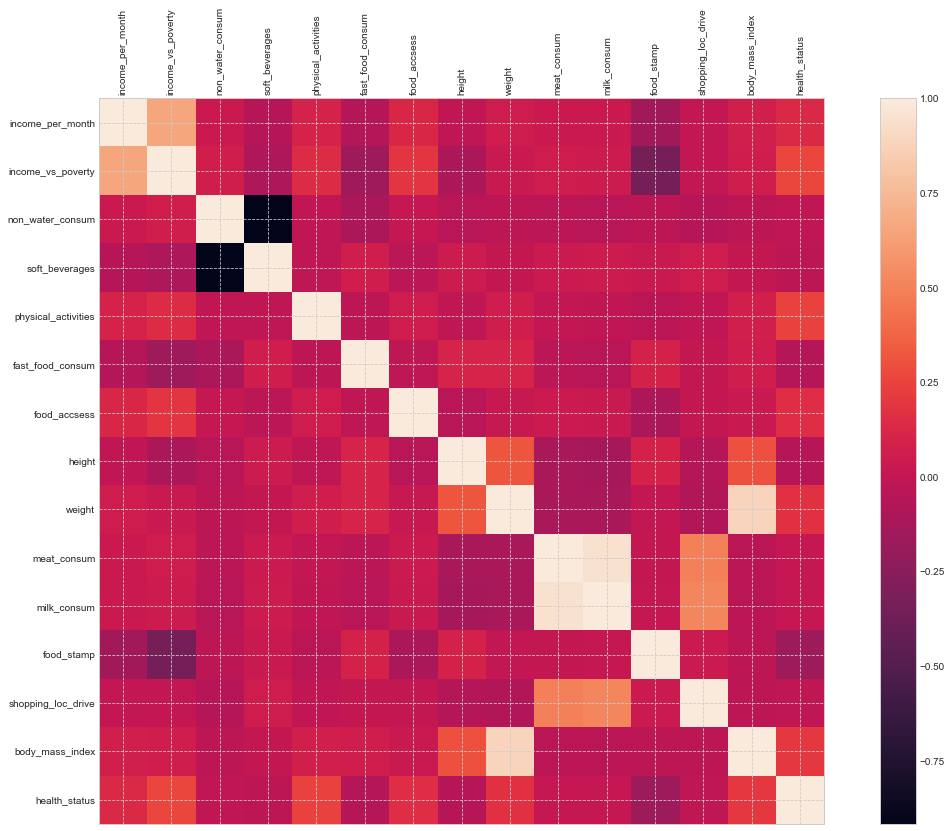

In [57]:
fn_plot_correlation_large_matrix(df_ehresp_us)

Let also run a test by isolation of a single value out of a variable and test the hypothesis that respondents who pick their grocery shopping location based on food quality will tend to report better health status. Let us isolate the variable (setting it to 1) and resetting all other options to 0. Let us examine before and after to see if there is any significant change in results. 

In [58]:
print("Before Isolation:")
fn_calculate_correlation_between_two_features(df_ehresp_us, "shopping_loc_drive", "health_status")
df_ehresp_us_isolation_test=df_ehresp_us.copy()
df_ehresp_us_isolation_test["shopping_loc_drive"]=df_ehresp_us_isolation_test["shopping_loc_drive"].replace(-1,0)
df_ehresp_us_isolation_test["shopping_loc_drive"]=df_ehresp_us_isolation_test["shopping_loc_drive"].replace(1,0)
df_ehresp_us_isolation_test["shopping_loc_drive"]=df_ehresp_us_isolation_test["shopping_loc_drive"].replace(3,0)
df_ehresp_us_isolation_test["shopping_loc_drive"]=df_ehresp_us_isolation_test["shopping_loc_drive"].replace(4,0)
df_ehresp_us_isolation_test["shopping_loc_drive"]=df_ehresp_us_isolation_test["shopping_loc_drive"].replace(5,0)
df_ehresp_us_isolation_test["shopping_loc_drive"]=df_ehresp_us_isolation_test["shopping_loc_drive"].replace(6,0)
df_ehresp_us_isolation_test["shopping_loc_drive"]=df_ehresp_us_isolation_test["shopping_loc_drive"].replace(2,1)
print("After Isolation:")
fn_calculate_correlation_between_two_features(df_ehresp_us_isolation_test, "shopping_loc_drive", "health_status")

Before Isolation:
Low Negative Correlation: -0.017
After Isolation:
Low Negative Correlation: -0.019


Apparently the isolation approach did not bring much change in the correlation between variables. We are ready to conclude some patterns we drew from this chapter as well:

One can conclude the following observations:
* **(#3001) Monthly Household Income**
<br> Low Positive Correlation
* **(#3002) Income vs Poverty**
<br> Low Positive Correlation
* **(#3003) Soft Drinks Consumption**
<br> Low Negative Correlation
* **(#3004) Physical Activity**
<br> Low Positive Correlation
* **(#3005) Fast Food Consumption**
<br> Low Negative Correlation
* **(#3006) Height/Weight**
<br> Low Negative/Positive Correlation
* **(#3007) Meat Consumption**
<br> Low Positive Correlation
* **(#3008) Milk Consumption**
<br> Low Positive Correlation
* **(#3009) Shopping Location**
<br> Low Negative Correlation
* **(#3010) BMI**
<br> Low Positive Correlation

# 5. Paper Conclusion

Within this paper we examined different scenarios for a number of input variables, calculated and plotted their impact on target measures such as `life expectance at birth`, `under 5 years mortality rate` and `health status` so we can investigate the broader question "What makes us sick" or better yet "what affects our longevity". 

**The following datasets were loaded, cleansed, modelled and analyzed:**
<br> 1. Economics and Demographics (per country worldwide over years)
<br> 2. Food and Drink (per country worldwide over years)
<br> 3. ATUS Health Status Survey (in USA, snapshot from 2015)

**The following major conclusions can be drawn:**
* Health and Longevity is clearly tied to geographic location where Europe, North America, Australia and certain SE Asia countries lead the pack. This is tied to the economic development and possibly cultural differences and social phenomena. 
* Health and Longevity changed over the centuries with certain countries falling or passing the bar. A steep curve ahead can be observed for those countries that let the industrial revolution in the beginning of the 20th century
* A curious fact is that Bulgaria was actually within the leading group of countries in the 19th century and lost its position in the 20th.
* Unfortunate environment phenomena (such as those in Haiti in 2010) and human driven wars affect longevity to a big extend and leave a historical mark
* GDP per Capita has strong positive correlation towards Health and Longevity
* The Suicide Rate is a weak connection towards understanding longevity and low child mortality rate. It's rather a social unpredictable phenomenon. 
* Industry Size (as part of GDP) is a low correlation to Health.
* Opposed to Industry it is interesting to observe [Services] and [Agriculture] variables and their moderate to strong correlation towards our health target measures. The Life Expenditure seems positively correlated in countries that base their economy on Services (normally developed countries) and negatively correlated in countries that base their economy primarily on Agriculture (normally under-developed countries).
* Water Withdrawal levels do not impact Health and Longevity despite popular media image for thirst in the third world countries.
* Coal Usage is not a good predictor for health. It's impact is rather non-tangible with the world environmental health being the stake. Opposite story with similar output are the CO2 Emissions. 
* Urbanization, Electricity Usage Levels are strongly correlated to health and longevity. Apparently the countries with population in the cities show better results, live longer. This can be easily tied back to GDP as well. 
* Blood Pressure is a good indicator for health overall but likely due to the immaterial change in values it showed low correlation to life expectancy. 
* BMI is a common variables in two of the datasets surprisingly showing different results. In the opening Gapminer dataset (with impartial data for life expectancy) BMI shows strong correlation. Meanwhile in the ATUS human partial response it shows low correlation towards their self-evaluated Health Status. This is a clear example of partial vs impartial evaluations in data science. 
* Cholesterol, Calories and Sugar Intake and three strongly correlated variables towards life expectancy. This is aligned with the common understanding that a diet scrutiny may be critical for the long-term well-being of a person. 
* Reportedly nearly 80% of the human respondents in the ATUS survey report above average health status. There are at least a couple of possible reasons towards this: (i) improper survey sample of people being well and positive regarding filling in a survey, or (ii) just being well aligned with the fact the United States is a well developed country (also aligned with the GDP correlation from chapter 1)
* All inspected variables from the ATUS dataset tend to be low correlated towards the target measure. This reduces the confidence in the user responses. 
* Monthly Household Income and Income vs Poverty variables are low correlated despite being a strongly related to GDP and GDP being a strong correlation to Life Expectancy. This conflicts likely due to human driven responses. 
* All examines food groups (soft drinks, fast food, meat and milk) are also in low correlation despite studies of their negative impact on human health. This is likely due to the instant (right-now) type of responses to the question "how healthy do you feel". 
* Similar results are observed on the Physical Activities variable where low correlation opposes the common understanding.
* Height/Weight variables practically form the BMI variable which was already discussed on a previous line.

<center>"Health is a crown on the head of a person that only an ill person can see"</center> 